In [1]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import networkx as nx
import pandas as pd
import numpy as np
from numpy import unique
from scipy.stats import zscore,spearmanr,pearsonr
import seaborn as sns
import matplotlib.pylab as plt
import os.path
% pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning:

pylab import has clobbered these variables: ['plot', 'plt']
`%matplotlib` prevents importing * from pylab and numpy



In [793]:
! git pull

Already up-to-date.


In [24]:
import numpy as np
from scipy import stats, linalg

def partial_corr(C):
    """
    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
    for the remaining variables in C.
    Parameters
    ----------
    C : array-like, shape (n, p)
        Array with the different variables. Each column of C is taken as a variable
    Returns
    -------
    P : array-like, shape (p, p)
        P[i, j] contains the partial correlation of C[:, i] and C[:, j] controlling
        for the remaining variables in C.
    """
    
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]

            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
        
    return P_corr

In [25]:
from scipy.signal import butter,filtfilt

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

import statsmodels.api as sm

def getCorrelationfromModel(y,fd):
    dmnIdeal=pd.read_csv('/home/jmuraskin/Projects/NFB/analysis/DMN_ideal_2.csv')
    fbModel=dmnIdeal['Wander']-dmnIdeal['Focus']
    model=sm.OLS(y,sm.add_constant(np.column_stack((fbModel,array(fd)))))
    results = model.fit()
    return sign(results.rsquared_adj)*np.sqrt(abs(results.rsquared_adj))
    

In [143]:
censorDirectory='/home/jmuraskin/Projects/CCD/working_v1/censor_directory/'
if not os.path.exists(censorDirectory):
    os.mkdir(censorDirectory)
SubjInfo = pd.read_csv('/home/jmuraskin/Projects/CCD/CCD-scripts/NARSAD_stimulus_JM.csv')
# SubjInfo.set_index('JM_INTERNAL',inplace=True)
dmnIdeal=pd.read_csv('/home/jmuraskin/Projects/NFB/analysis/DMN_ideal_2.csv')

rsnDirectory='/home/jmuraskin/Projects/CCD/working_v1/rsn'
if not os.path.exists(rsnDirectory):
    os.mkdir(rsnDirectory)

drFileLocation='/home/jmuraskin/Projects/CCD/CPAC-out/pipeline_CCD_v1'

GroupDF=[]
numberOfICs=10
columnNames=[]
for rsnNumber in range(numberOfICs):
    columnNames.append('RSN%d' % rsnNumber)

Rmap=numpy.zeros((numberOfICs,numberOfICs))

filterOn=False
zscoreOn=True
lowpass=0.1
globalNR=0

censorThreshold=0.3

for indx,row in SubjInfo.iterrows():
    
    subj = row['JM_INTERNAL']
    print subj
    for scan in range(1,3,1):
        drFilePath = '%s/%s_data_/spatial_map_timeseries_for_DR/_scan_feedback_%d/_csf_threshold_0.96/_gm_threshold_0.7/_wm_threshold_0.96/_compcor_ncomponents_5_selector_pc10.linear1.wm0.global%d.motion1.quadratic1.gm0.compcor1.csf1/_spatial_map_PNAS_Smith09_rsn10/spatial_map_timeseries.txt' % (drFileLocation,subj,scan,globalNR)
        df=[]
        subjHasBoth=True
        if os.path.isfile('%s/%s_data_/spatial_map_timeseries_for_DR/_scan_feedback_%d/_csf_threshold_0.96/_gm_threshold_0.7/_wm_threshold_0.96/_compcor_ncomponents_5_selector_pc10.linear1.wm0.global%d.motion1.quadratic1.gm0.compcor1.csf1/_spatial_map_PNAS_Smith09_rsn10/spatial_map_timeseries.txt' % (drFileLocation,subj,1,globalNR)) and os.path.isfile('%s/%s_data_/spatial_map_timeseries_for_DR/_scan_feedback_%d/_csf_threshold_0.96/_gm_threshold_0.7/_wm_threshold_0.96/_compcor_ncomponents_5_selector_pc10.linear1.wm0.global%d.motion1.quadratic1.gm0.compcor1.csf1/_spatial_map_PNAS_Smith09_rsn10/spatial_map_timeseries.txt' % (drFileLocation,subj,2,globalNR)):
            try:
                df = pd.read_csv(drFilePath,header=None,names=columnNames,delim_whitespace=True)
                df['Subject_ID'] = subj
                df['Subject'] = indx
                df.index.name = 'TR'
                df.reset_index(level=0,inplace=True)
                if row['SCAN_%d_PARADIGM' % scan]==1 or row['SCAN_%d_PARADIGM' % scan]==3:
                    for rsn in columnNames:
                        if filterOn:
                            if zscoreOn:
                                df[rsn]=pd.Series(-1*zscore(butter_lowpass_filter(df[rsn][:],lowpass,0.5)))
                            else:
                                df[rsn]=pd.Series(-1*butter_lowpass_filter(df[rsn][:],lowpass,0.5))

                        else:
                            if zscoreOn:
                                df[rsn]=pd.Series(-1*zscore(df[rsn][:]))
                            else:
                                df[rsn]=pd.Series(-1*df[rsn][:])


                    df['flip']=-1
                else:
                    for rsn in columnNames:
                        if filterOn:
                            if zscoreOn:
                                df[rsn]=pd.Series(zscore(butter_lowpass_filter(df[rsn][:],lowpass,0.5)))
                            else:
                                df[rsn]=pd.Series(butter_lowpass_filter(df[rsn][:],lowpass,0.5))

                        else:
                            if zscoreOn:
                                df[rsn]=pd.Series(zscore(df[rsn][:]))
                            else:
                                df[rsn]=pd.Series(df[rsn][:])


                    df['flip']=1
                df[columnNames].to_csv('%s/%s_%s.csv' % (rsnDirectory,subj,'FEEDBACK' if row['SCAN_%d_FEEDBACK' % scan]==1 else 'NOFEEDBACK'),header=False,index=False)
                df['FB'] = 'FEEDBACK' if row['SCAN_%d_FEEDBACK' % scan]==1 else 'NOFEEDBACK'
                df['scanorder']=scan
                df['modelcorr']=pearsonr(dmnIdeal['Wander']-dmnIdeal['Focus'],df['RSN3'])[0]
                data=zscore(np.array([dmnIdeal['Wander'],-1*dmnIdeal['Focus'],df['RSN3']]).T,axis=0)
                pcorr=partial_corr(data)
                df['pCorr_Wander']=pcorr[2][0]
                df['pCorr_Focus']=pcorr[2][1]
                
#                 df['DMN']=pd.Series(zscore(nuisanceRegression(df[list(set(columnNames)-set(['RSN3']))],df['RSN3'])))
                #load meanFD scores
                fdFilePath='%s/%s_data_/frame_wise_displacement/_scan_feedback_%d/FD.1D' % (drFileLocation,subj,scan)
                fd=pd.read_csv(fdFilePath,header=None,names=['fd'],delim_whitespace=True)
                df['meanFD']=fd.mean()[0]
                df['OLS_Rsquared']=getCorrelationfromModel(df['RSN3'],fd['fd'])
                df['fd']=fd
                fd[fd>censorThreshold]=1
                fd[fd<1]=0
                if not os.path.exists(censorDirectory+subj):
                    os.mkdir(censorDirectory+subj)
                fd.to_csv('%s%s/feedback_run_%d.csv' % (censorDirectory,subj,scan),header=None,index=False)
                
                
                
#                 fdFilePath='%s/%s_data_/frame_wise_displacement/_scan_tra/FD.1D' % (drFileLocation,subj)
#                 fd=pd.read_csv(fdFilePath,header=None,names=['fd'],delim_whitespace=True)
#                 df['train_meanFD']=fd.mean()[0]
                if len(GroupDF)==0:
                    GroupDF=df
                else:
                    GroupDF=pd.concat((GroupDF,df),ignore_index=True)
            except:
                print 'No DR .txt file found or error'

GroupDF.reset_index(inplace=True)

motionInfo=GroupDF.groupby(['Subject_ID','FB','scanorder']).mean()['meanFD']
motionInfo.to_csv('../analysis/CCD_meanFD.csv')
perfInfo=GroupDF.groupby(['Subject_ID','FB','scanorder']).mean()['modelcorr']
perfInfo.to_csv('../analysis/CCD_performance.csv')

# scanInfo=GroupDF.groupby(['Subject_ID','FB']).mean()['scanorder']
# scanInfo.to_csv('../analysis/CCD_scaninfo.csv')

CCD074
CCD052
CCD099
CCD094
CCD072
CCD098
CCD060
CCD088
CCD073
CCD040
CCD095
CCD083
CCD064
CCD071
CCD041
CCD062
CCD061
CCD096
CCD063
CCD067
CCD085
CCD091
CCD092
CCD093
CCD059
CCD066
CCD084
CCD075
CCD086
CCD080
CCD082
CCD089
CCD097
CCD076
CCD065
CCD081
CCD042
CCD090
CCD012
CCD014
CCD015
CCD016
CCD017
CCD018
CCD019
CCD020
CCD021
CCD022
CCD023
CCD024
CCD025
CCD026
CCD027
CCD031
CCD032
CCD033
CCD034
CCD051
CCD087
CCD053


/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



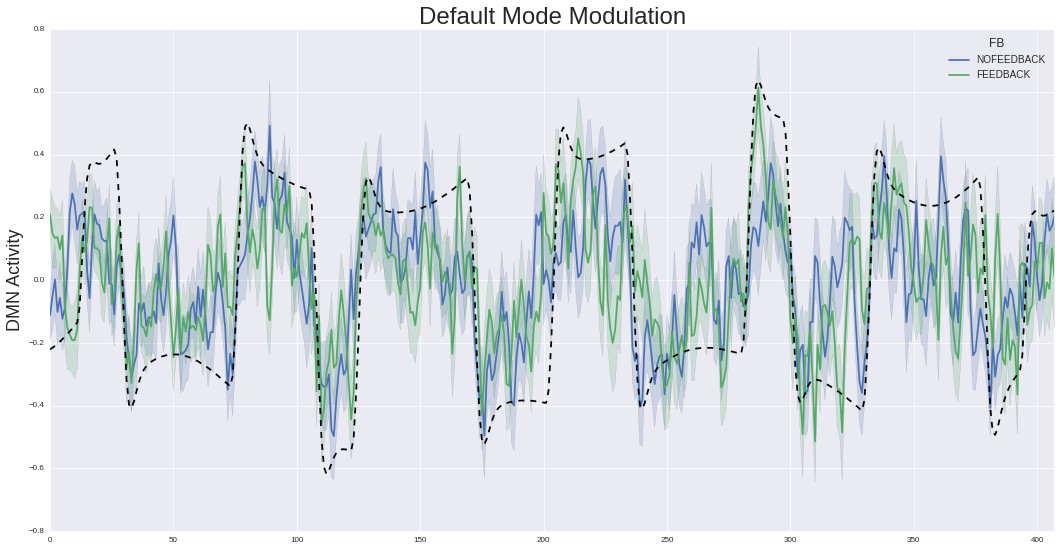

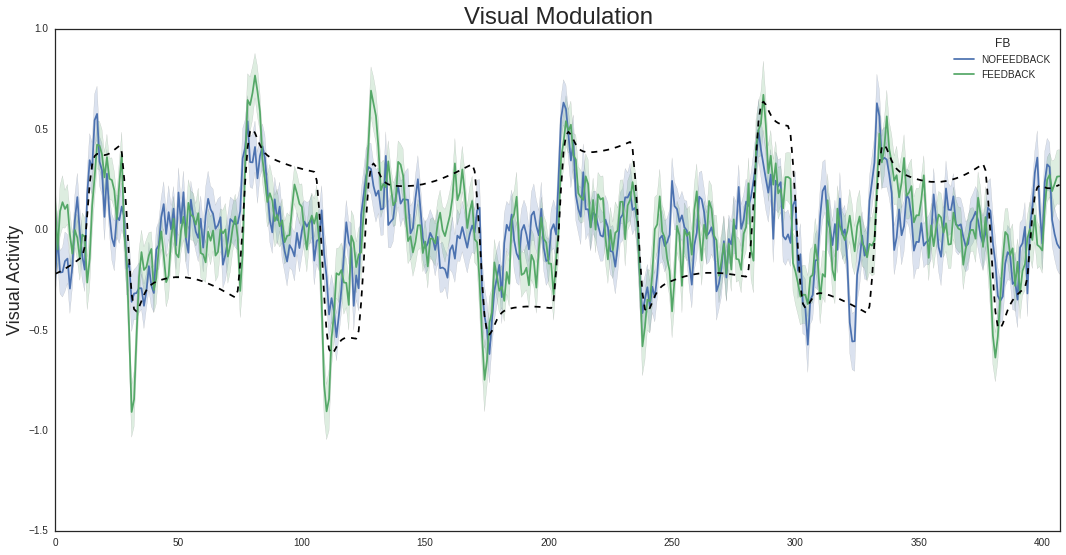

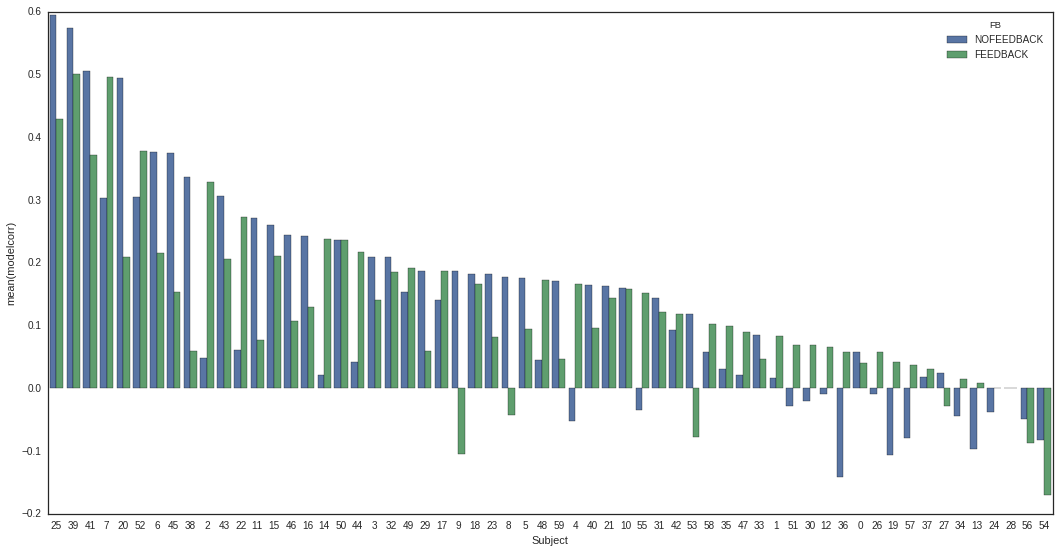

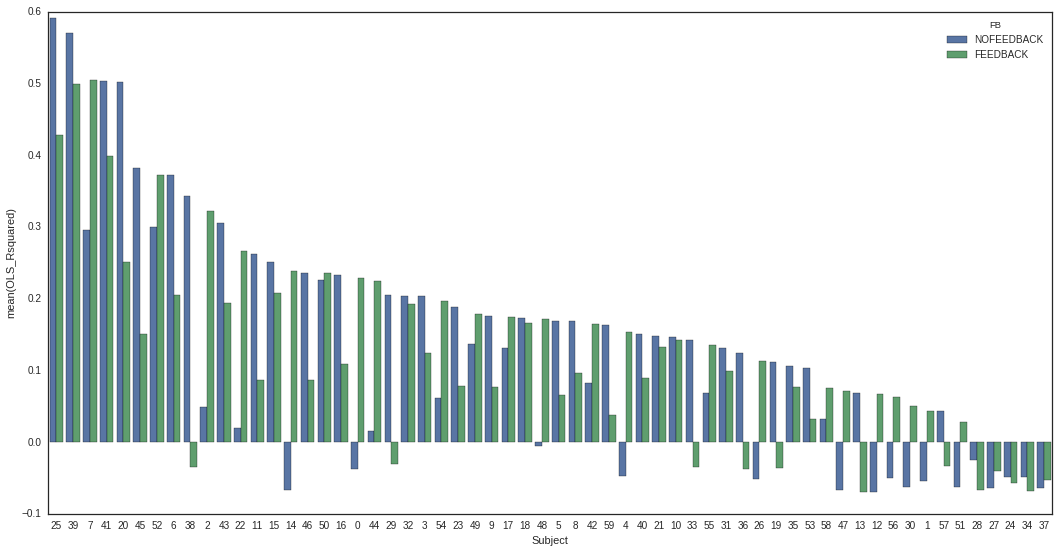

In [29]:
RejectMotion=False
motionThresh=.2

#reject large motion subjects
allsubj=unique(GroupDF['Subject_ID'])
motionReject=unique((GroupDF[GroupDF.meanFD>motionThresh]['Subject_ID']))
if RejectMotion:
    goodsubj=np.setdiff1d(allsubj,motionReject)
else:
    goodsubj=allsubj
    



DMN_name='RSN3'

sns.set_context("paper")
#plt.subplots(2,1,figsize=(12, 6))
f, axarr = plt.subplots(1, sharex=True,figsize=(18, 9))
sns.set(style="white")
dmnPlot=sns.tsplot(data=GroupDF[GroupDF.Subject_ID.isin(goodsubj)],time='TR',unit='Subject',condition='FB',value=DMN_name,ci=68)
#get ideal DMN time line
dmnIdeal=pd.read_csv('/home/jmuraskin/Projects/NFB/analysis/DMN_ideal_2.csv')
dmnPlot.plot((dmnIdeal['Wander']-dmnIdeal['Focus'])/(3*max(dmnIdeal['Wander'])),'k--')
#dmnPlot.plot(dmnIdeal['Focus'][4:]/(3*max(dmnIdeal['Focus'])),'r--')
# dmnPlot.set_ylim([-.8,.8])
dmnPlot.set_ylabel('DMN Activity',{'fontsize':18})
dmnPlot.set_xlabel('')
dmnPlot.set_title('Default Mode Modulation',{'fontsize':24})
f.savefig('DMN_timeseries.pdf', dpi=600)

f, axarr = plt.subplots(1, sharex=True,figsize=(18, 9))
sns.set(style="white")
dmnPlot=sns.tsplot(data=GroupDF[GroupDF.Subject_ID.isin(goodsubj)],time='TR',unit='Subject',condition='FB',value='RSN0',ci=68)
#get ideal DMN time line
dmnIdeal=pd.read_csv('/home/jmuraskin/Projects/NFB/analysis/DMN_ideal_2.csv')
dmnPlot.plot((dmnIdeal['Wander']-dmnIdeal['Focus'])/(3*max(dmnIdeal['Wander'])),'k--')
#dmnPlot.plot(dmnIdeal['Focus'][4:]/(3*max(dmnIdeal['Focus'])),'r--')
# dmnPlot.set_ylim([-.8,.8])
dmnPlot.set_ylabel('Visual Activity',{'fontsize':18})
dmnPlot.set_xlabel('')
dmnPlot.set_title('Visual Modulation',{'fontsize':24})
f.savefig('Visual_timeseries.pdf', dpi=600)

f, axarr = plt.subplots(1, sharex=True,figsize=(18, 9))
sns.set(style="white")

maxModel=GroupDF[GroupDF.Subject_ID.isin(goodsubj)].groupby(['Subject'])['modelcorr'].max().sort_values(ascending=False)
sortedOrder=maxModel.index

sns.barplot(data=GroupDF[GroupDF.Subject_ID.isin(goodsubj)],x='Subject',y='modelcorr',hue='FB',order=sortedOrder)
f.savefig('Subject_ModelCorrelations.pdf', dpi=600)




f, axarr = plt.subplots(1, sharex=True,figsize=(18, 9))
sns.set(style="white")
maxModel=GroupDF[GroupDF.Subject_ID.isin(goodsubj)].groupby(['Subject'])['OLS_Rsquared'].max().sort_values(ascending=False)
sortedOrder=maxModel.index

sns.barplot(data=GroupDF[GroupDF.Subject_ID.isin(goodsubj)],x='Subject',y='OLS_Rsquared',hue='FB',order=sortedOrder)
# f.savefig('Subject_ModelCorrelations.pdf', dpi=600)


#dmnPlot.legend(loc='lower left')

#dmnPlot.legend(loc='lower left')
#dmnPlot.title('')
# sns.despine(bottom=True,ax=axarr[0])


# for tick in axarr[1].xaxis.get_major_ticks():
#                 tick.label.set_fontsize(14)
        
# for tick in axarr[1].yaxis.get_major_ticks():
#                 tick.label.set_fontsize(14)

# for tick 
# in axarr[0].yaxis.get_major_ticks():
#                 tick.label.set_fontsize(14)
        
# f.savefig('DMN_Modulation.pdf',dpi=600)

In [27]:
subject_list=goodsubj
perfDiff=np.array(GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='FEEDBACK'],axis=0)].groupby('Subject_ID').mean()['modelcorr'])-\
np.array(GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='NOFEEDBACK'],axis=0)].groupby('Subject_ID').mean()['modelcorr'])

sns.distplot(perfDiff)



NameError: name 'goodsubj' is not defined

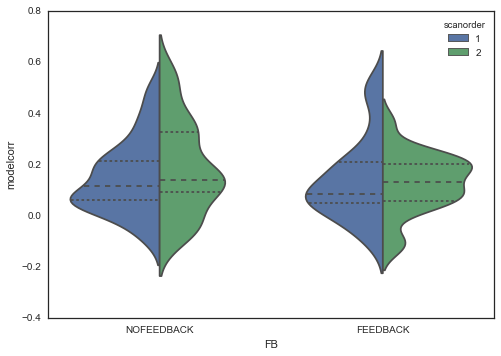

In [512]:
plt.figure()
sns.violinplot(data=GroupDF[GroupDF.Subject_ID.isin(goodsubj)],x='FB',y='modelcorr',hue='scanorder',split='True',bw=.4,inner='quartile')
# plt.savefig('ScanOrder_ModelCorrelations.pdf',dpi=600)

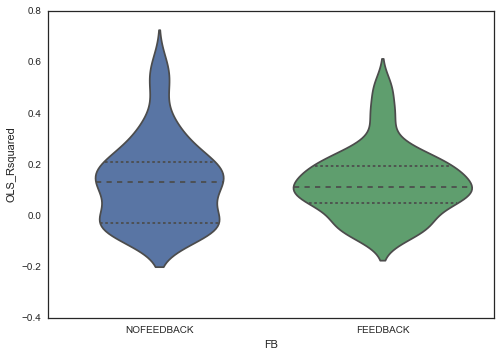

In [516]:
plt.figure()
sns.violinplot(data=GroupDF[GroupDF.Subject_ID.isin(goodsubj)],x='FB',y='OLS_Rsquared',split='True',bw=.4,inner='quartile')


In [175]:
SubjectDF = GroupDF[GroupDF.Subject_ID.isin(goodsubj)].groupby(['Subject_ID','FB','TR']).mean()
addBias=False
add_motion=True

OLSdata=[]
for indx,subj in enumerate(unique(GroupDF[GroupDF.Subject_ID.isin(goodsubj)]['Subject_ID'])):
    modelX=np.column_stack((dmnIdeal['Focus'],dmnIdeal['Wander']))
    if add_motion:
        modelX=np.column_stack((modelX,GroupDF[np.all([GroupDF.Subject_ID==subj,GroupDF.FB==feedback],axis=0)]['fd']))
        C=[-1,1,0]
    else:
        C=[-1,1]
    if addBias:
        modelX=sm.add_constant(modelX)

    for feedback in ['FEEDBACK','NOFEEDBACK']:
        for rsn in columnNames:
            y=SubjectDF.loc[subj,feedback][rsn]

            model = sm.OLS(y, modelX)
            results = model.fit()

            #Get output variablies of interest
            coefs = results.params[0:2]
            coefsName=['focus','wander']
            r2adj = results.rsquared_adj
            diff = results.t_test(C).effect[0]
            tmpDF=pd.DataFrame({'coefs':coefs,'cName':coefsName})
            tmpDF['R2']=r2adj
            tmpDF['cDiff']=diff
            tmpDF['RSN']=rsn
            tmpDF['FB']=feedback
            tmpDF['subj']=subj
            if len(OLSdata)==0:
                OLSdata=tmpDF
            else:
                OLSdata=pd.concat((OLSdata,tmpDF),ignore_index=True)
                
            
            


NameError: name 'feedback' is not defined

In [174]:
plt.figure()
sns.factorplot(data=OLSdata,y='coefs',x='cName',hue='FB',units='subj',col='RSN',col_wrap=5,ci=68,kind='bar')
plt.figure()
sns.factorplot(data=OLSdata,y='R2',x='FB',units='subj',col='RSN',col_wrap=5,ci=68,kind='bar')


NameError: name 'OLSdata' is not defined

In [ ]:
OLSd

In [200]:
import statsmodels.api as sm

highPassCutOff=.25
addBias=1

modelX=np.column_stack((butter_lowpass_filter(-1*dmnIdeal['Focus'],highPassCutOff,.5),butter_lowpass_filter(-1*dmnIdeal['Wander'],highPassCutOff,.5)))
if addBias:
    modelX=sm.add_constant(modelX)

SubjectDF = GroupDF[GroupDF.Subject_ID.isin(goodsubj)].groupby(['Subject_ID','FB','TR']).mean()



for indx,subj in enumerate(unique(GroupDF[GroupDF.Subject_ID.isin(goodsubj)]['Subject_ID'])):
    
    for feedback in ['FEEDBACK','NOFEEDBACK']:
        y =SubjectDF.loc[subj,feedback]['RSN3']
        model = sm.OLS(y, modelX)
        results = model.fit()
        if feedback=='FEEDBACK':
            subjResults=results.params[:]
            results_FB=results
        else:
            subjResults=np.vstack((subjResults,results.params[:]))
            results_nFB=results
#     subjResults=np.diff(subjResults,axis=0)
    if addBias:
        resultDict={'FB_Bias':subjResults[0][0],'FB_Focus':subjResults[0][1],'FB_Wander':subjResults[0][2],'noFB_Bias':subjResults[1][0],'noFB_Focus':subjResults[1][1],'noFB_Wander':subjResults[1][2],'FB_results':results_FB,'noFB_results':results_nFB}
    else:
        resultDict={'FB_Focus':subjResults[0][0],'FB_Wander':subjResults[0][1],'noFB_Focus':subjResults[1][0],'noFB_Wander':subjResults[1][1],'FB_results':results_FB,'noFB_results':results_nFB}
    if indx==0:
        groupResults=pd.DataFrame(resultDict,index=[subj])
    else:
        groupResults=pd.concat((groupResults,pd.DataFrame(resultDict,index=[subj])))


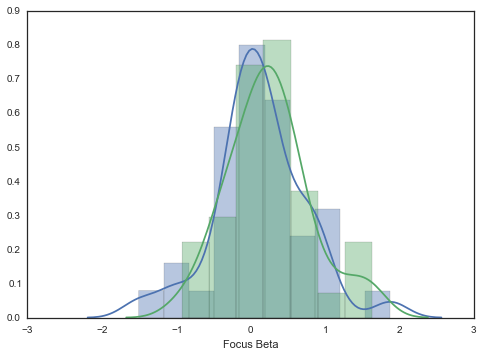

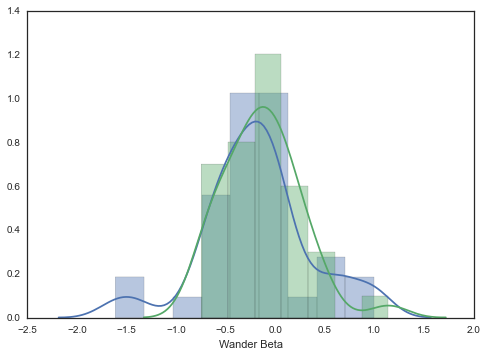

In [9]:
plt.figure()
sns.distplot(groupResults.FB_Focus,label='Feedback')
sns.distplot(groupResults.noFB_Focus,label='No Feedback')
plt.xlabel('Focus Beta')
plt.figure()
sns.distplot(groupResults.FB_Wander,label='Feedback')
sns.distplot(groupResults.noFB_Wander,label='No Feedback')
plt.xlabel('Wander Beta')

In [527]:
heatmapDF=GroupDF[GroupDF.Subject_ID.isin(goodsubj)].groupby(['Subject_ID','FB','TR']).mean()
hmDiff=np.zeros((10,10,len(unique(GroupDF[GroupDF.Subject_ID.isin(goodsubj)]['Subject_ID']))))
hmFB=hmDiff.copy()
hmNFB=hmDiff.copy()
for indx,subj in enumerate(unique(GroupDF[GroupDF.Subject_ID.isin(goodsubj)]['Subject_ID'])):
    hmFB[:,:,indx]=partial_corr(heatmapDF.loc[subj,'FEEDBACK'][columnNames])
    hmNFB[:,:,indx]=partial_corr(heatmapDF.loc[subj,'NOFEEDBACK'][columnNames].corr())
    hmDiff[:,:,indx]=np.arctan(hmFB[:,:,indx])-np.arctan(hmNFB[:,:,indx])

import pickle
pickle.dump({'FB':hmFB,'nFB':hmNFB,'hmDiff':hmDiff},open('CCD-pcorr_RSN_networks.p','wb'))

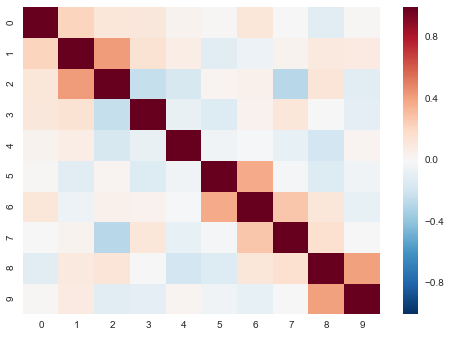

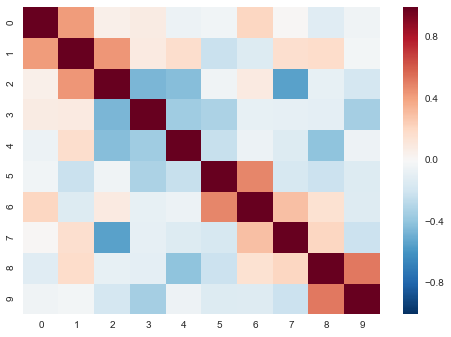

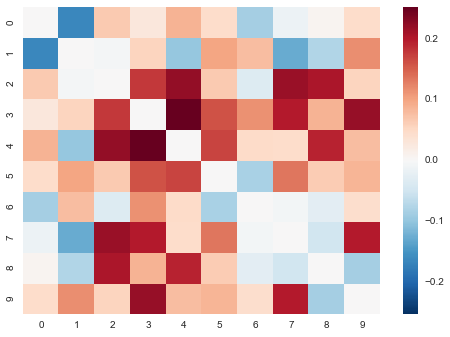

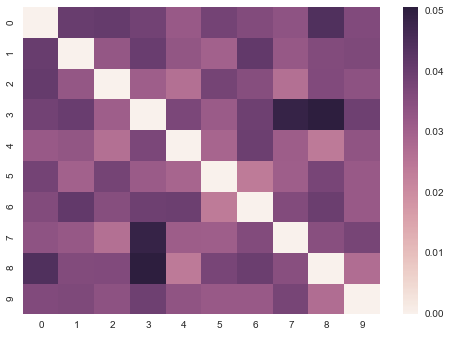

In [528]:
sns.heatmap(np.mean(hmFB,axis=2))
plt.figure()
sns.heatmap(np.mean(hmNFB,axis=2))

plt.figure()
sns.heatmap(np.mean(hmDiff,axis=2))
plt.figure()
sns.heatmap(np.std(hmDiff,axis=2)/sqrt(len(goodsubj)))


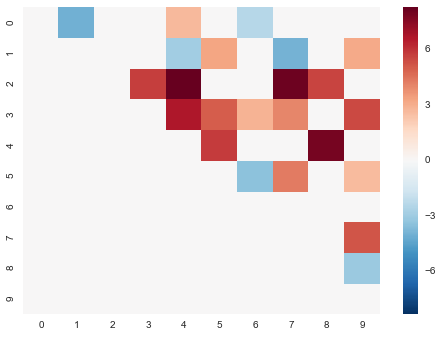

In [529]:
from scipy.stats import ttest_1samp
from mne.stats.multi_comp import fdr_correction
t,p=ttest_1samp(hmDiff,0,axis=2)
row,column=np.triu_indices(10,1)
rowl,columnl=np.tril_indices(10)
# sns.heatmap(t)
p05,padj=fdr_correction(p[row,column],0.05)
fdr_corrected=t.copy()
fdr_corrected[rowl,columnl]=0
fdr_corrected[row,column]=t[row,column]*p05
pickle.dump({'fdrDiff':fdr_corrected},open('CCD-pCorr-FDR.p','wb'))
sns.heatmap(fdr_corrected)
# plt.savefig('FB_gt_nFB_tMap.pdf',dpi=300)

In [507]:
heatmapDF=GroupDF[GroupDF.Subject_ID.isin(goodsubj)].groupby(['Subject_ID','FB','TR']).mean()
hmDiff=np.zeros((10,10,len(unique(GroupDF[GroupDF.Subject_ID.isin(goodsubj)]['Subject_ID']))))
hmFB=hmDiff.copy()
hmNFB=hmDiff.copy()
for indx,subj in enumerate(unique(GroupDF[GroupDF.Subject_ID.isin(goodsubj)]['Subject_ID'])):
    hmFB[:,:,indx]=heatmapDF.loc[subj,'FEEDBACK'][columnNames].corr()
    hmNFB[:,:,indx]=heatmapDF.loc[subj,'NOFEEDBACK'][columnNames].corr()
    hmDiff[:,:,indx]=np.arctan(heatmapDF.loc[subj,'FEEDBACK'][columnNames].corr())*np.sqrt(405)-np.arctan(heatmapDF.loc[subj,'NOFEEDBACK'][columnNames].corr())*np.sqrt(405)

import pickle
pickle.dump({'FB':hmFB,'nFB':hmNFB,'hmDiff':hmDiff},open('CCD-RSN_networks.p','wb'))

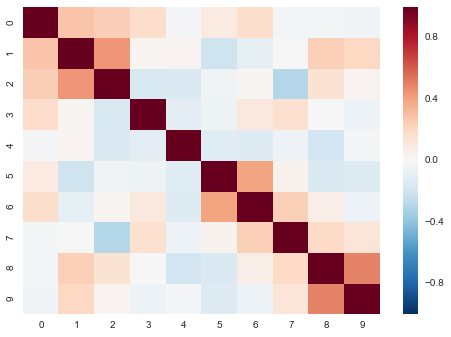

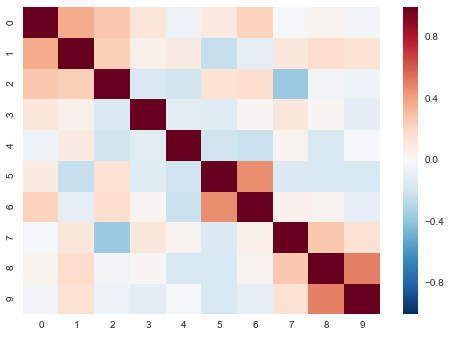

In [508]:
sns.heatmap(np.mean(hmFB,axis=2))
plt.savefig('Average_Feedback_RSN10.pdf',dpi=300)



plt.figure()
sns.heatmap(np.mean(hmNFB,axis=2))
plt.savefig('Average_No_Feedback_RSN10.pdf',dpi=300)



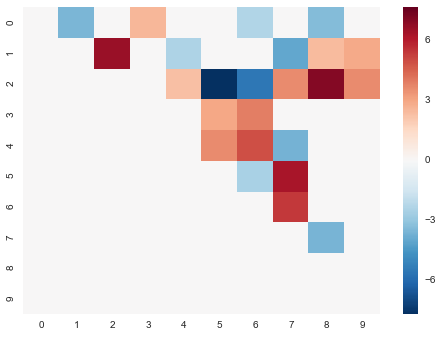

In [510]:
from scipy.stats import ttest_1samp
from mne.stats.multi_comp import fdr_correction
t,p=ttest_1samp(hmDiff,0,axis=2)
row,column=np.triu_indices(10,1)
rowl,columnl=np.tril_indices(10)
# sns.heatmap(t)
p05,padj=fdr_correction(p[row,column],0.05)
fdr_corrected=t.copy()
fdr_corrected[rowl,columnl]=0
fdr_corrected[row,column]=t[row,column]*p05
pickle.dump({'fdrDiff':fdr_corrected},open('CCD-FDR.p','wb'))
sns.heatmap(fdr_corrected)
plt.savefig('FB_gt_nFB_tMap.pdf',dpi=300)

In [13]:
help(fdr_correction)

Help on function fdr_correction in module mne.stats.multi_comp:

fdr_correction(pvals, alpha=0.05, method='indep')
    P-value correction with False Discovery Rate (FDR)
    
    Correction for multiple comparison using FDR.
    
    This covers Benjamini/Hochberg for independent or positively correlated and
    Benjamini/Yekutieli for general or negatively correlated tests.
    
    Parameters
    ----------
    pvals : array_like
        set of p-values of the individual tests.
    alpha : float
        error rate
    method : 'indep' | 'negcorr'
        If 'indep' it implements Benjamini/Hochberg for independent or if
        'negcorr' it corresponds to Benjamini/Yekutieli.
    
    Returns
    -------
    reject : array, bool
        True if a hypothesis is rejected, False if not
    pval_corrected : array
        pvalues adjusted for multiple hypothesis testing to limit FDR
    
    Notes
    -----
    Reference:
    Genovese CR, Lazar NA, Nichols T.
    Thresholding of statistica

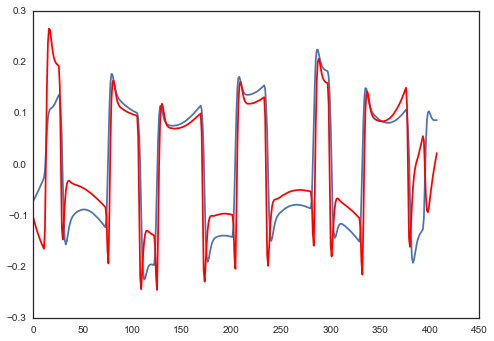

In [14]:
plt.plot(range(408),np.dot(modelX,groupResults.loc['CCD017']['FB_results'].params[:]))
plt.plot(range(408),np.dot(modelX,groupResults.loc['CCD017']['noFB_results'].params[:]),'r')

SyntaxError: invalid syntax (<ipython-input-15-e8baab77e191>, line 2)

In [ ]:
sns.heatmap(heatmaps)

In [ ]:
heatmapDF=GroupDF.groupby(['Subject_ID','FB','TR']).mean()

numSubjs=len(unique(heatmapDF.index.get_level_values('Subject_ID')))
winlength=30
fb=np.zeros((numSubjs,408,10,10))
indx=0
for subject in unique(heatmapDF.index.get_level_values('Subject_ID')):
    fb[indx,:,:,:]=np.arctan(heatmapDF.loc[subject,'FEEDBACK'][columnNames].rolling(window=winlength,center=False).corr())*np.sqrt(winlength-3)
    indx+=1


nofb=np.zeros((numSubjs,408,10,10))
indx=0
for subject in unique(heatmapDF.index.get_level_values('Subject_ID')):
    nofb[indx,:,:,:]=np.arctan(heatmapDF.loc[subject,'NOFEEDBACK'][columnNames].rolling(window=winlength,center=False).corr())*np.sqrt(winlength-3)
    indx+=1

In [ ]:
plt.plot(range(408),np.squeeze(fb[0,:,3,7]))
plt.plot(range(408),.2+(dmnIdeal['Wander']-dmnIdeal['Focus'])/(10*max(dmnIdeal['Wander'])),'k--')

In [ ]:
plt.plot(range(408),np.squeeze(nofb[0,:,2,3]))
plt.plot(range(408),.2+(dmnIdeal['Wander']-dmnIdeal['Focus'])/(10*max(dmnIdeal['Wander'])),'k--')

In [17]:
from scipy.stats import pearsonr

# sns.heatmap(np.mean(fb))

In [ ]:
nofbMap=np.zeros((10,10))
nofbpMap=np.ones((10,10))
for rsn in range(10):
    for rsn1 in range(10):
        if rsn!=rsn1:
            nofbMap[rsn,rsn1],nofbpMap[rsn,rsn1]=pearsonr(np.squeeze(nofb[15:392,rsn,rsn1]/len(unique(heatmapDF.index.get_level_values('Subject_ID')))),(dmnIdeal['Wander']-dmnIdeal['Focus'])[15:392])
plt.figure()
sns.heatmap(nofbMap)
plt.figure()
sns.heatmap(1-nofbpMap)

In [ ]:
fbMap=np.zeros((numSubjs,10,10))
fbpMap=np.ones((numSubjs,10,10))
for subj in range(numSubjs):
    for rsn in range(10):
        for rsn1 in range(10):
            if rsn!=rsn1:
                fbMap[subj,rsn,rsn1],fbpMap[subj,rsn,rsn1]=pearsonr(np.squeeze(fb[subj,15:392,rsn,rsn1]),(dmnIdeal['Wander']-dmnIdeal['Focus'])[15:392])


In [ ]:
nofbMap=np.zeros((numSubjs,10,10))
nofbpMap=np.ones((numSubjs,10,10))
for subj in range(numSubjs):
    for rsn in range(10):
        for rsn1 in range(10):
            if rsn!=rsn1:
                nofbMap[subj,rsn,rsn1],nofbpMap[subj,rsn,rsn1]=pearsonr(np.squeeze(nofb[subj,15:392,rsn,rsn1]),(dmnIdeal['Wander']-dmnIdeal['Focus'])[15:392])


In [16]:
from scipy.stats import ttest_1samp

In [ ]:
t,p=ttest_1samp(fbMap-nofbMap,0)

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage,fcluster
np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation

In [ ]:
# make data a sample x feature
# shapeData=fb[:,:,:,:].shape
row,column=np.triu_indices(10,1)
X=fb[:,15:392:2,row,column]
X = X.reshape(X.shape[0]*X.shape[1],X.shape[2])
X.shape

In [ ]:
Z = linkage(X, 'ward')

In [ ]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(Z, pdist(X))
c

In [ ]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [ ]:
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
)


In [ ]:
k=2
clusterIndx=fcluster(Z, k, criterion='maxclust')

In [ ]:
clusterTimeseries=clusterIndx.reshape(numSubjs,378/2)

In [ ]:
plt.plot(np.mean(clusterTimeseries,axis=0))

pearsonr(np.mean(clusterTimeseries,axis=0),(dmnIdeal['Wander']-dmnIdeal['Focus'])[15:392:2])

In [ ]:
cluster1=np.mean(X[clusterIndx==1,:],axis=0)
cluster2=np.mean(X[clusterIndx==2,:],axis=0)
cluster2Map=np.zeros((10,10))
cluster1Map=np.zeros((10,10))
cluster1Map[row,column]=cluster1
cluster2Map[row,column]=cluster2

In [ ]:
sns.heatmap(cluster2Map-cluster1Map,vmin=-3,vmax=3)

In [ ]:
sns.heatmap(cluster2Map,vmin=-3,vmax=3)

In [18]:
from sklearn import linear_model
from sklearn import cross_validation 
from sklearn import metrics

def LinRegression(X,y):
    regr = linear_model.LinearRegression()
    regr.fit(X,y)
    
    score=regr.score(X,y)
    resids=y-regr.predict(X)
    
    return score,resids,regr.coef_,regr.predict(X)


def leaveOneOutCV(clf,X,y,LOO=False):
    from sklearn.cross_validation import LeaveOneOut,KFold
    coefs=np.zeros((X.shape[1],))
    intercept=0.0
    predicted=np.zeros((len(y),))
    if LOO:
        loo = LeaveOneOut(n=len(y))
        numFolds=len(y)
    else:
        loo = KFold(n=len(y),n_folds=10)
        numFolds=10
    for train_index, test_index in loo:
        clf.fit(X[train_index,:],y[train_index])
        predicted[test_index]=clf.predict(X[test_index,:])
        intercept+=clf.intercept_
        coefs+=clf.coef_
    
    intercept=intercept/numFolds
    coefs=coefs/numFolds
    return predicted,intercept,coefs

def bayesianRidge(X,y):
    clf = linear_model.BayesianRidge(compute_score=True)
    predicted = cross_validation.cross_val_predict(clf, X,y,cv=408)
    return clf,predicted

In [19]:
def GroupRegression(GroupDF,feedback):
    SubjectDF = GroupDF[GroupDF.Subject_ID.isin(goodsubj)].groupby(['Subject_ID','FB','TR']).mean()
    clf = linear_model.LinearRegression()
    
    for indx,subj in enumerate(unique(GroupDF['Subject_ID'])):
        predicted,intercepts,coef = leaveOneOutCV(clf,np.array(SubjectDF.loc[subj,feedback][columnNames]),dmnIdeal['Wander']-dmnIdeal['Focus'])
        if indx==0:
            groupGLM=pd.DataFrame({'TR':range(408),'predicted':predicted,'subj':[subj]*408})
            coefs=pd.DataFrame({'Coef':coef,'pe':range(10),'subj':[subj]*10})
            performance=pd.DataFrame({'R':[spearmanr(dmnIdeal['Wander']-dmnIdeal['Focus'],predicted)[0]],'subj':[subj]})
        else:
            df=pd.DataFrame({'TR':range(408),'predicted':predicted,'subj':[subj]*408})
            groupGLM=pd.concat((groupGLM,df),ignore_index=True)
            coefs=pd.concat((coefs,pd.DataFrame({'Coef':coef,'pe':range(10),'subj':[subj]*10})),ignore_index=True)
            performance=pd.concat((performance,pd.DataFrame({'R':[spearmanr(dmnIdeal['Wander']-dmnIdeal['Focus'],predicted)[0]],'subj':[subj]})),ignore_index=True)

    return groupGLM,coefs,performance

    
fb_pred,fb_coefs,fb_performance=GroupRegression(GroupDF[GroupDF.Subject_ID.isin(goodsubj)],'FEEDBACK')
print pearsonr(fb_pred.groupby('TR').mean()['predicted'],dmnIdeal['Wander']-dmnIdeal['Focus'])
nfb_pred,nfb_coefs,nfb_performance=GroupRegression(GroupDF[GroupDF.Subject_ID.isin(goodsubj)],'NOFEEDBACK')
print pearsonr(nfb_pred.groupby('TR').mean()['predicted'],dmnIdeal['Wander']-dmnIdeal['Focus'])
fb_pred['fb']='FEEDBACK'
nfb_pred['fb']='NOFEEDBACK'
predictions=pd.concat((fb_pred,nfb_pred),ignore_index=True)

fb_coefs['fb']='FEEDBACK'
nfb_coefs['fb']='NOFEEDBACK'
coefs=pd.concat((fb_coefs,nfb_coefs),ignore_index=True)

fb_performance['fb']='FEEDBACK'
nfb_performance['fb']='NOFEEDBACK'
performance=pd.concat((fb_performance,nfb_performance),ignore_index=True)

(0.76798486692582413, 1.4101830475367659e-80)
(0.74710485050132824, 5.1388001926244431e-74)


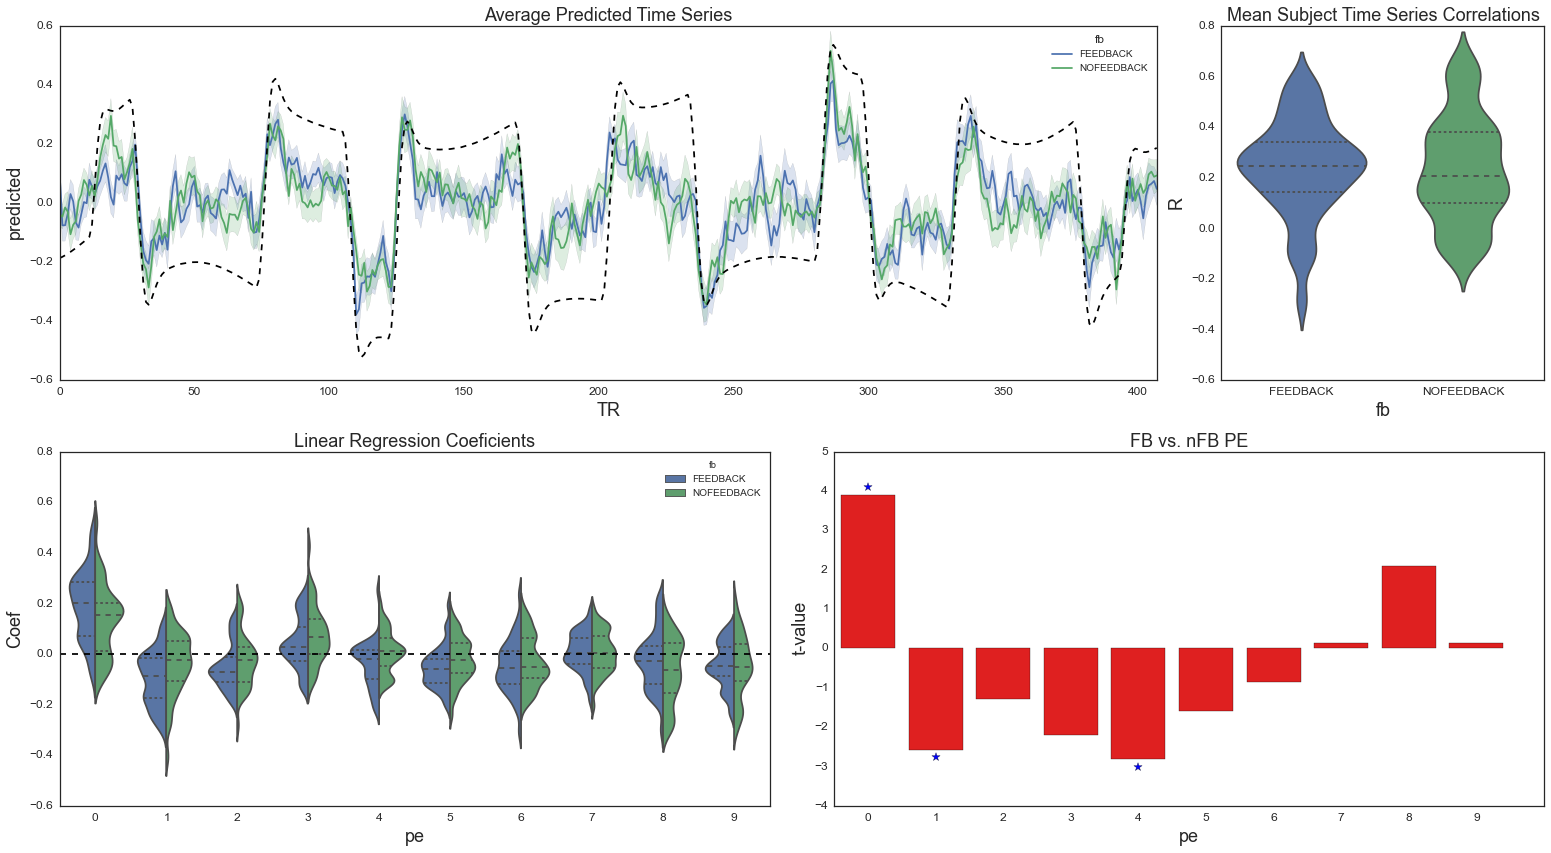

In [69]:
f=plt.figure(figsize=(22,12))
ax1=plt.subplot2grid((2,4),(0,0), colspan=3)
ax2=plt.subplot2grid((2,4),(0,3))
ax3=plt.subplot2grid((2,4),(1,0), colspan=2)
ax4=plt.subplot2grid((2,4),(1,2), colspan=2)


sns.tsplot(data=predictions,time='TR',value='predicted',unit='subj',condition='fb',ax=ax1)
ax1.plot((dmnIdeal['Wander']-dmnIdeal['Focus'])/3,'k--')
ax1.set_title('Average Predicted Time Series')

g=sns.violinplot(data=performance,x='fb',y='R',split=True,bw=.3,inner='quartile',ax=ax2)
# plt.close(g.fig)
ax2.set_title('Mean Subject Time Series Correlations')
g=sns.violinplot(data=coefs,x='pe',y='Coef',hue='fb',split=True,bw=.3,inner='quartile',ax=ax3)
g.plot([-1,10],[0,0],'k--')
g.set_xlim([-.5,9.5])
# plt.close(g.fig)
ax3.set_title('Linear Regression Coeficients')

t,p=ttest_1samp(np.array(fb_coefs['Coef']-nfb_coefs['Coef']).reshape(len(unique(GroupDF[GroupDF.Subject_ID.isin(goodsubj)]['Subject_ID'])),10),0)
p05,padj=fdr_correction(p,0.05)

sns.barplot(x=range(len(t)),y=t,ax=ax4,color='Red')
for idx,pFDR in enumerate(p05):
    if pFDR:
        ax4.scatter(idx,t[idx]+ sign(t[idx])*0.2,marker='*',s=75)
ax4.set_xlim([-0.5,10])
ax4.set_xlabel('pe')
ax4.set_ylabel('t-value')
ax4.set_title('FB vs. nFB PE')

for ax in [ax1,ax2,ax3,ax4]:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
        item.set_fontsize(18)
    for item in (ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)
        
f.tight_layout()
f.savefig('RSN_LinearRegPrediction.pdf',dpi=300)

In [30]:
# Setup Block design analysis for barplots
WanderBlocks=[[14,29],[78,108],[127,172],[206,236],[285,300],[334,379]]
FocusBlocks=[[31,76],[110,125],[174,204],[238,283],[302,332],[381,396]]

blockedDF=[]
for rsn in columnNames:
    #enumerate(unique(GroupDF[(GroupDF['feedback_sleep']+GroupDF['train_sleep'])==0]['Subject']))
    for fb in ['FEEDBACK','NOFEEDBACK']:
        for subjNo,subj in enumerate(unique(GroupDF[GroupDF.Subject_ID.isin(goodsubj)]['Subject'])):
            WanderBlockAve=[]
            FocusBlockAve=[]
            WanderBlockStd=[]
            FocusBlockStd=[]
            FocusBlockNumber=[]
            WanderBlockNumber=[]
            tmpDF=GroupDF[np.all([GroupDF['Subject']==subj,GroupDF['FB']==fb],axis=0)]
            for indx,wblock in enumerate(WanderBlocks):
                WanderBlockAve.append(np.mean(tmpDF[np.all([tmpDF['TR']>=wblock[0],tmpDF['TR']<=wblock[1]],axis=0)][rsn]))
                WanderBlockNumber.append(indx)
                WanderBlockStd.append(np.std(tmpDF[np.all([tmpDF['TR']>=wblock[0],tmpDF['TR']<=wblock[1]],axis=0)][rsn]))
            for indx,fblock in enumerate(FocusBlocks):
                FocusBlockAve.append(np.mean(tmpDF[np.all([tmpDF['TR']>=fblock[0],tmpDF['TR']<=fblock[1]],axis=0)][rsn]))
                FocusBlockNumber.append(indx)
                FocusBlockStd.append(np.std(tmpDF[np.all([tmpDF['TR']>=fblock[0],tmpDF['TR']<=fblock[1]],axis=0)][rsn]))

            average=np.concatenate((WanderBlockAve,FocusBlockAve))
            std=np.concatenate((WanderBlockStd,FocusBlockStd))
            indxs=np.concatenate((WanderBlockNumber,FocusBlockNumber))
            wf=np.concatenate((['Wander']*6,['Focus']*6))
            tmpDF=pd.DataFrame({'zscore':np.divide(average,std),'average':average,'std':std,'blocks':indxs,'Condition':wf,'FB':fb})
            tmpDF['subj']=subj
            tmpDF['RSN']=rsn

            if len(blockedDF)<1:
                blockedDF=tmpDF
            else:
                blockedDF=pd.concat((blockedDF,tmpDF))

    #df=pd.DataFrame({'Subject':subj})

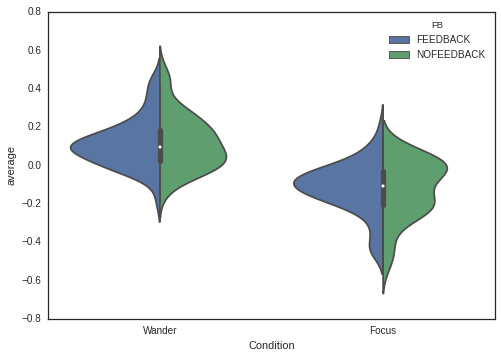

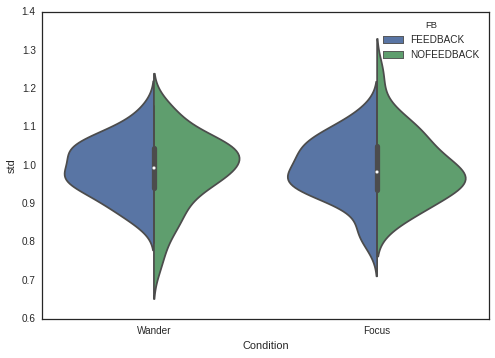

In [179]:
# Setup Block design analysis Up-Regulation (wander) and Down-Regulation (focus)
WanderBlocks=[[14,29],[78,108],[127,172],[206,236],[285,300],[334,379]]
FocusBlocks=[[31,76],[110,125],[174,204],[238,283],[302,332],[381,396]]

blockedDF=[]
for rsn in ['RSN3']:
    #enumerate(unique(GroupDF[(GroupDF['feedback_sleep']+GroupDF['train_sleep'])==0]['Subject']))
    for fb in ['FEEDBACK','NOFEEDBACK']:
        for subjNo,subj in enumerate(unique(GroupDF[GroupDF.Subject_ID.isin(goodsubj)]['Subject_ID'])):
            WanderBlockAve=[]
            FocusBlockAve=[]
            tmpDF=GroupDF[np.all([GroupDF['Subject_ID']==subj,GroupDF['FB']==fb],axis=0)]
            for indx,wblock in enumerate(WanderBlocks):
                if indx==0:
                    WanderBlockAve=tmpDF[np.all([tmpDF['TR']>=wblock[0],tmpDF['TR']<=wblock[1]],axis=0)][rsn]
                else:    
                    WanderBlockAve=pd.concat((WanderBlockAve,tmpDF[np.all([tmpDF['TR']>=wblock[0],tmpDF['TR']<=wblock[1]],axis=0)][rsn]))
            for indx,fblock in enumerate(FocusBlocks):
                if indx==0:
                    FocusBlockAve=tmpDF[np.all([tmpDF['TR']>=fblock[0],tmpDF['TR']<=fblock[1]],axis=0)][rsn]
                else:
                    FocusBlockAve=pd.concat((FocusBlockAve,tmpDF[np.all([tmpDF['TR']>=fblock[0],tmpDF['TR']<=fblock[1]],axis=0)][rsn]))
            average=[WanderBlockAve.mean(),FocusBlockAve.mean()]
            std=[WanderBlockAve.std(),FocusBlockAve.std()]
#             indxs=np.concatenate((WanderBlockNumber,FocusBlockNumber))
            wf=['Wander','Focus']
            tmpDF=pd.DataFrame({'average':average,'Condition':wf,'FB':[fb]*2,'std':std})
            tmpDF['subj']=subj
            tmpDF['RSN']=rsn

            if len(blockedDF)<1:
                blockedDF=tmpDF
            else:
                blockedDF=pd.concat((blockedDF,tmpDF))

    #df=pd.DataFrame({'Subject':subj})
plt.figure()
sns.violinplot(data=blockedDF,x='Condition',y='average',units='subj',hue='FB',split=True)

plt.figure()
sns.violinplot(data=blockedDF,x='Condition',y='std',units='subj',hue='FB',split=True)

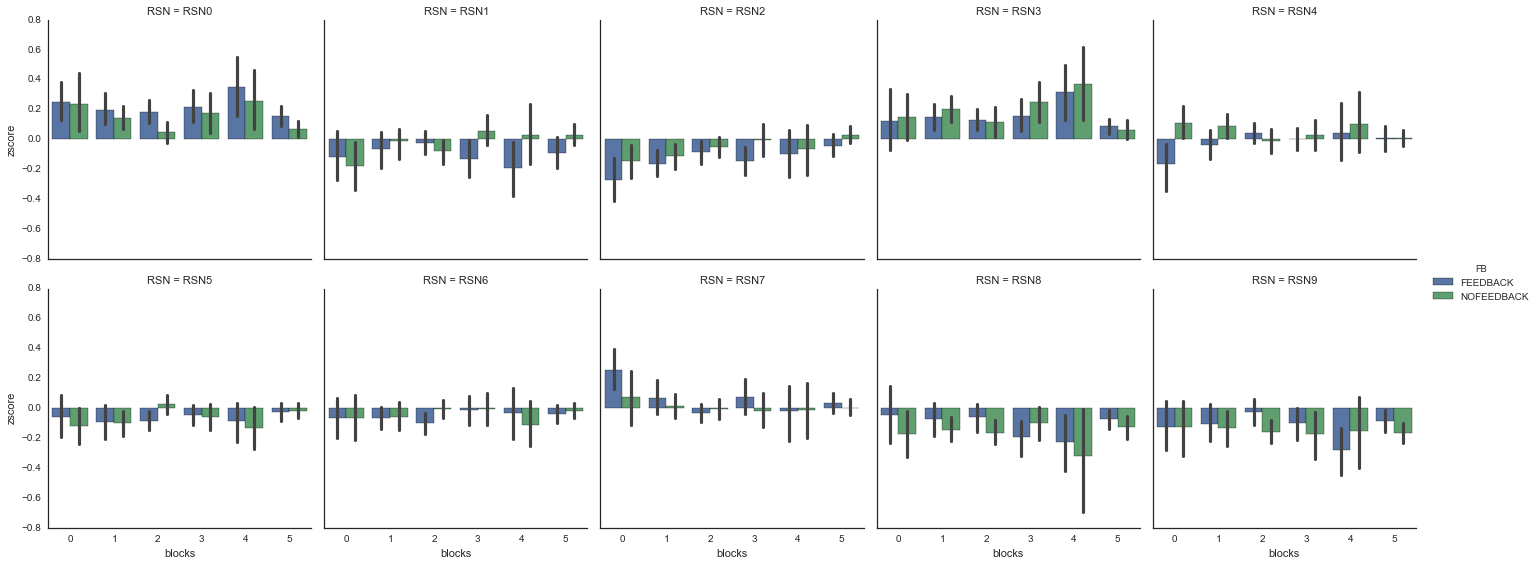

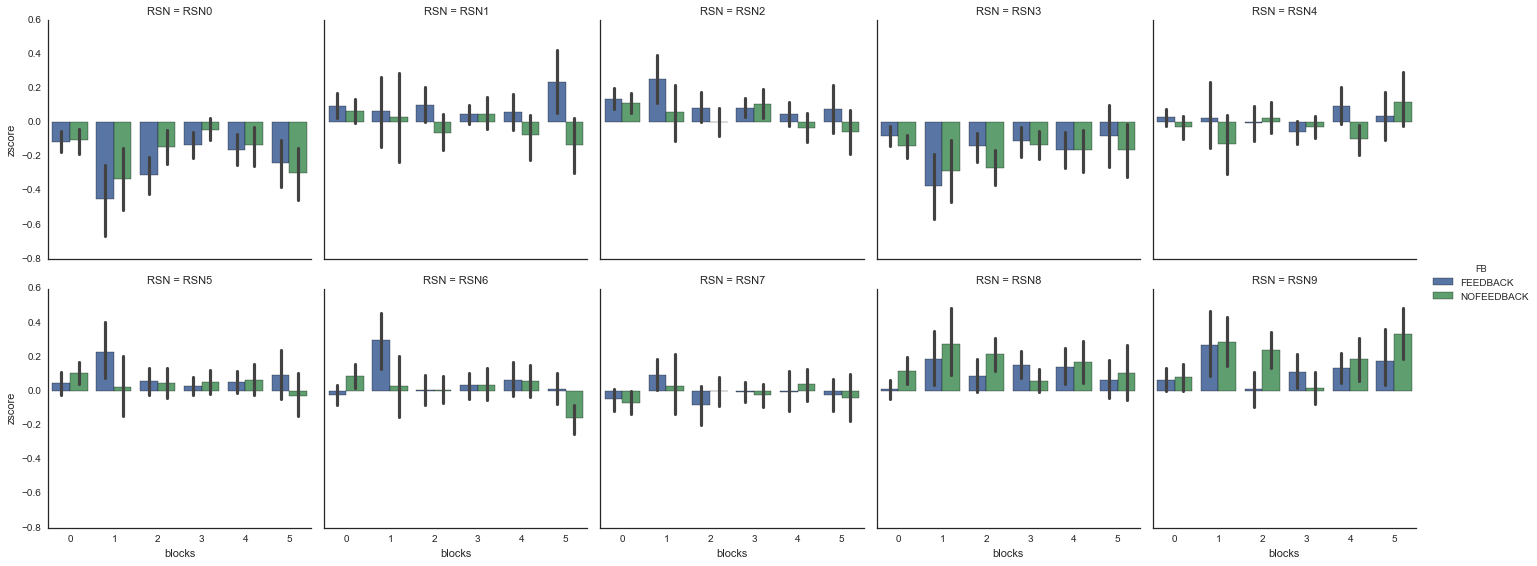

In [315]:
fig=sns.factorplot(x='blocks', y='zscore', data=blockedDF[blockedDF.Condition=='Wander'], hue='FB',col='RSN', col_wrap=5,kind='bar')

fig2=sns.factorplot(x='blocks', y='zscore', data=blockedDF[blockedDF.Condition=='Focus'], hue='FB',col='RSN', col_wrap=5,kind='bar')

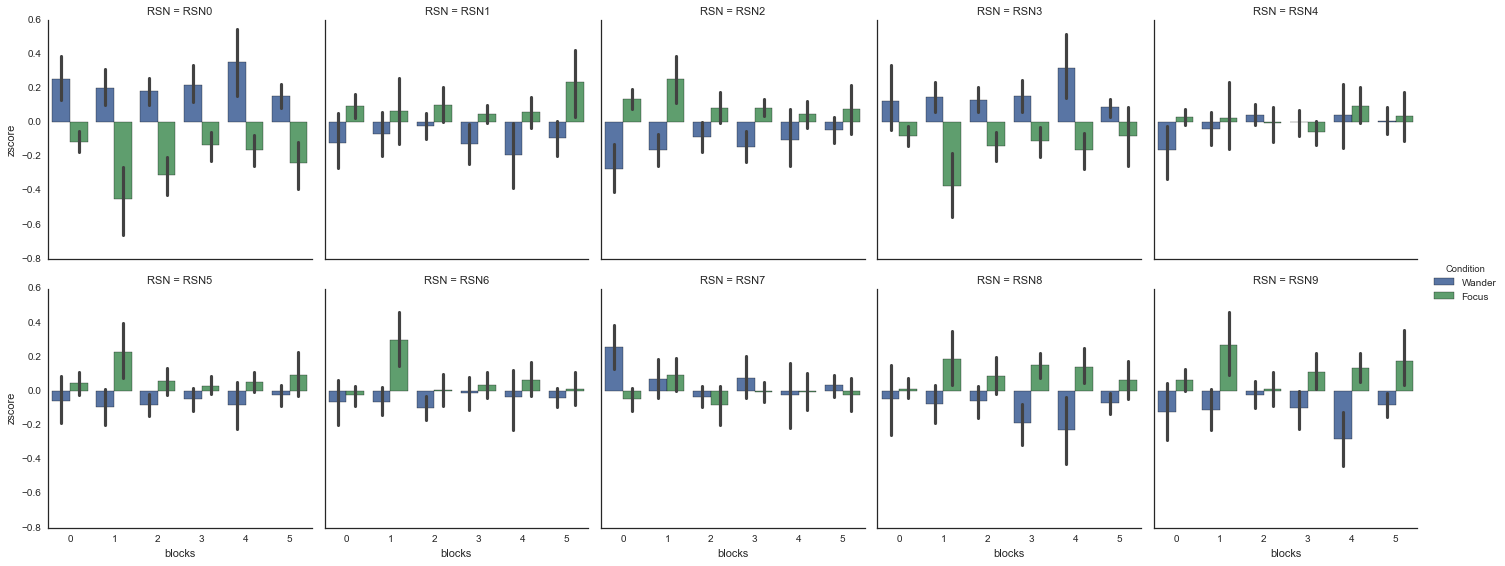

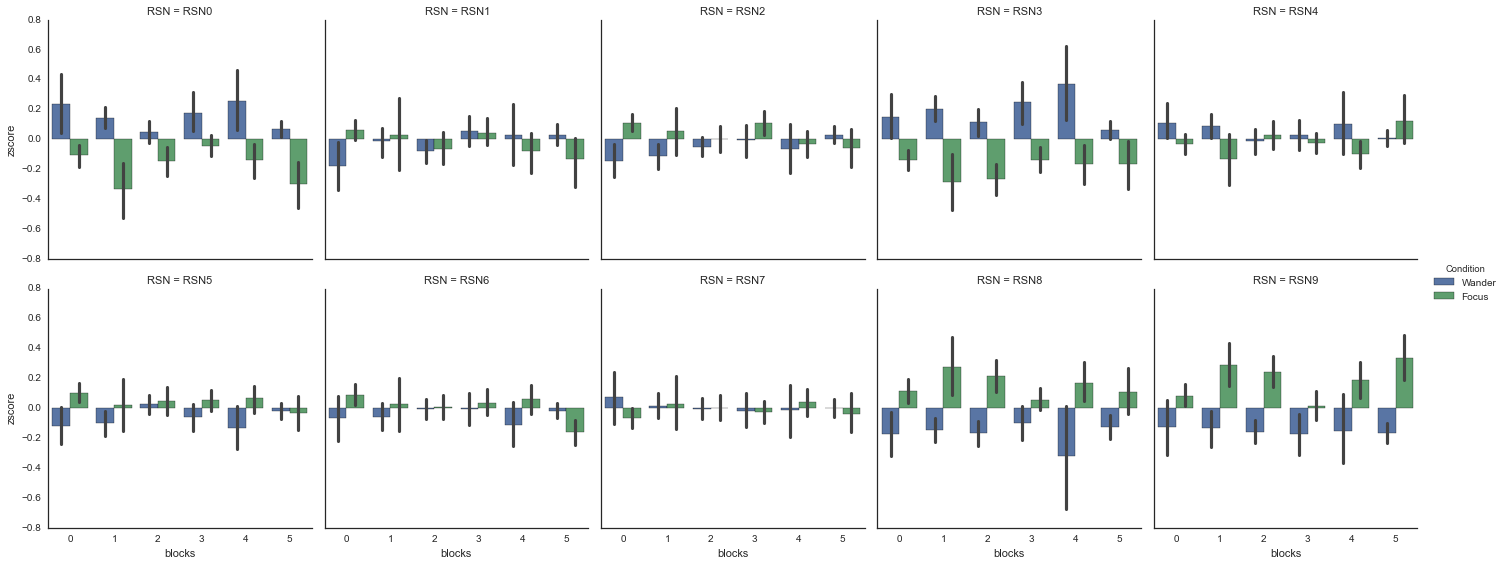

In [ ]:
fig=sns.factorplot(x='blocks', y='zscore', data=blockedDF[blockedDF.FB=='FEEDBACK'], hue='Condition',col='RSN', col_wrap=5,kind='bar')
fig2=sns.factorplot(x='blocks', y='zscore', data=blockedDF[blockedDF.FB=='NOFEEDBACK'], hue='Condition',col='RSN', col_wrap=5,kind='bar')

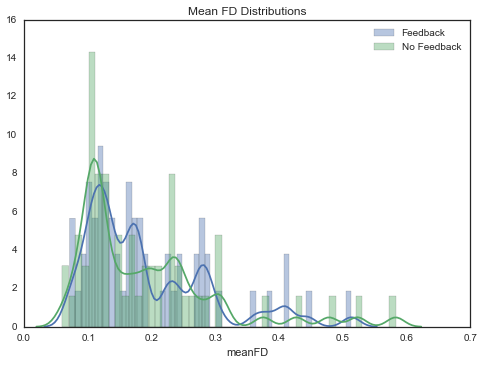

In [24]:
sns.distplot(GroupDF[GroupDF.FB=='FEEDBACK'].meanFD,label='Feedback')
sns.distplot(GroupDF[GroupDF.FB=='NOFEEDBACK'].meanFD,label='No Feedback')
plt.legend()
plt.title('Mean FD Distributions')
plt.savefig('MeanFD_Distro.png',dpi=600)
# sns.distplot(GroupDF.train_meanFD)

In [ ]:
print len(goodsubj)
goodsubj

In [ ]:
CCD_numbers=[12,14,15,16,17,18,19,20,21,22,23,24,25,26,27,31,32,33,34,40,42,51,
53,59,60,61,62,63,64,65,66,67,71,72,73,74,75,76,80,81,82,83,84,85,86,87,88,89,
90,91,92,93,95,96,97,98,99]
len(CCD_numbers)

In [ ]:
allsubj

In [ ]:
foldername

In [176]:
Wander=[]
for idx,wBlocks in enumerate(WanderBlocks):
    fw=GroupDF[np.all([GroupDF.Subject_ID.isin(goodsubj),GroupDF.TR>=wBlocks[0],GroupDF.TR<=wBlocks[1],GroupDF.FB=='FEEDBACK'],axis=0)][['TR']+['Subject_ID']+columnNames]
    if idx==0:
        Wander=fw
    else:
        Wander=pd.concat((Wander,fw),ignore_index=True)
Wander.drop('TR',inplace=True,axis=1)

Focus=[]
for idx,fBlocks in enumerate(FocusBlocks):
    fw=GroupDF[np.all([GroupDF.Subject_ID.isin(goodsubj),GroupDF.TR>=fBlocks[0],GroupDF.TR<=fBlocks[1],GroupDF.FB=='FEEDBACK'],axis=0)][['TR']+['Subject_ID']+columnNames]
    if idx==0:
        Focus=fw
    else:
        Focus=pd.concat((Focus,fw),ignore_index=True)
Focus.drop('TR',inplace=True,axis=1)

In [ ]:
wander=arctan(Wander.groupby(['Subject_ID']).corr())*sqrt(180-3)
focus=arctan(Focus.groupby(['Subject_ID']).corr())*sqrt(180-3)
diffFW=focus-wander

In [ ]:
# Get Group Means
WanderMean=np.zeros((10,10))
FocusMean=np.zeros((10,10))
diffMean=np.zeros((10,10,len(goodsubj)))

for indx,subj in enumerate(goodsubj):
    WanderMean+=wander.loc[subj][columnNames]
    FocusMean+=focus.loc[subj][columnNames]
    diffMean[:,:,indx]=diffFW.loc[subj][columnNames]
WanderMean/=len(goodsubj)
FocusMean/=len(goodsubj)

In [ ]:
fig=plt.figure(figsize=(8,6))
plt.subplot(1,2,1)
sns.heatmap(WanderMean)
plt.subplot(1,2,2)
sns.heatmap(FocusMean)
# plt.subplot(1,3,3)
# sns.heatmap(diffMean)

In [ ]:
t,p=ttest_1samp(diffMean,0,axis=2)
row,column=np.triu_indices(10,1)
rowl,columnl=np.tril_indices(10)
# sns.heatmap(t)
p05,padj=fdr_correction(p[row,column],0.05)
fdr_corrected=t.copy()
fdr_corrected[rowl,columnl]=0
fdr_corrected[row,column]=t[row,column]*p05
sns.heatmap(fdr_corrected)


In [32]:
blockedDF



,Condition,FB,average,std,subj,RSN
0,Wander,FEEDBACK,0.022316,0.941524,CCD012,RSN3
1,Focus,FEEDBACK,-0.045083,1.074858,CCD012,RSN3
0,Wander,FEEDBACK,0.435382,0.944752,CCD014,RSN3
1,Focus,FEEDBACK,-0.450389,0.896043,CCD014,RSN3
0,Wander,FEEDBACK,0.077151,1.155387,CCD015,RSN3
1,Focus,FEEDBACK,-0.126858,0.838622,CCD015,RSN3
0,Wander,FEEDBACK,0.309911,0.914033,CCD016,RSN3
1,Focus,FEEDBACK,-0.418428,0.930331,CCD016,RSN3
0,Wander,FEEDBACK,0.115006,0.855392,CCD017,RSN3
1,Focus,FEEDBACK,-0.107328,1.145879,CCD017,RSN3


                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                   60
Model:                            RLM   Df Residuals:                       42
Method:                          IRLS   Df Model:                           17
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 29 Sep 2016                                         
Time:                        14:53:58                                         
No. Iterations:                    50                                         
                     coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
const             -0.2051      0.155     -1.

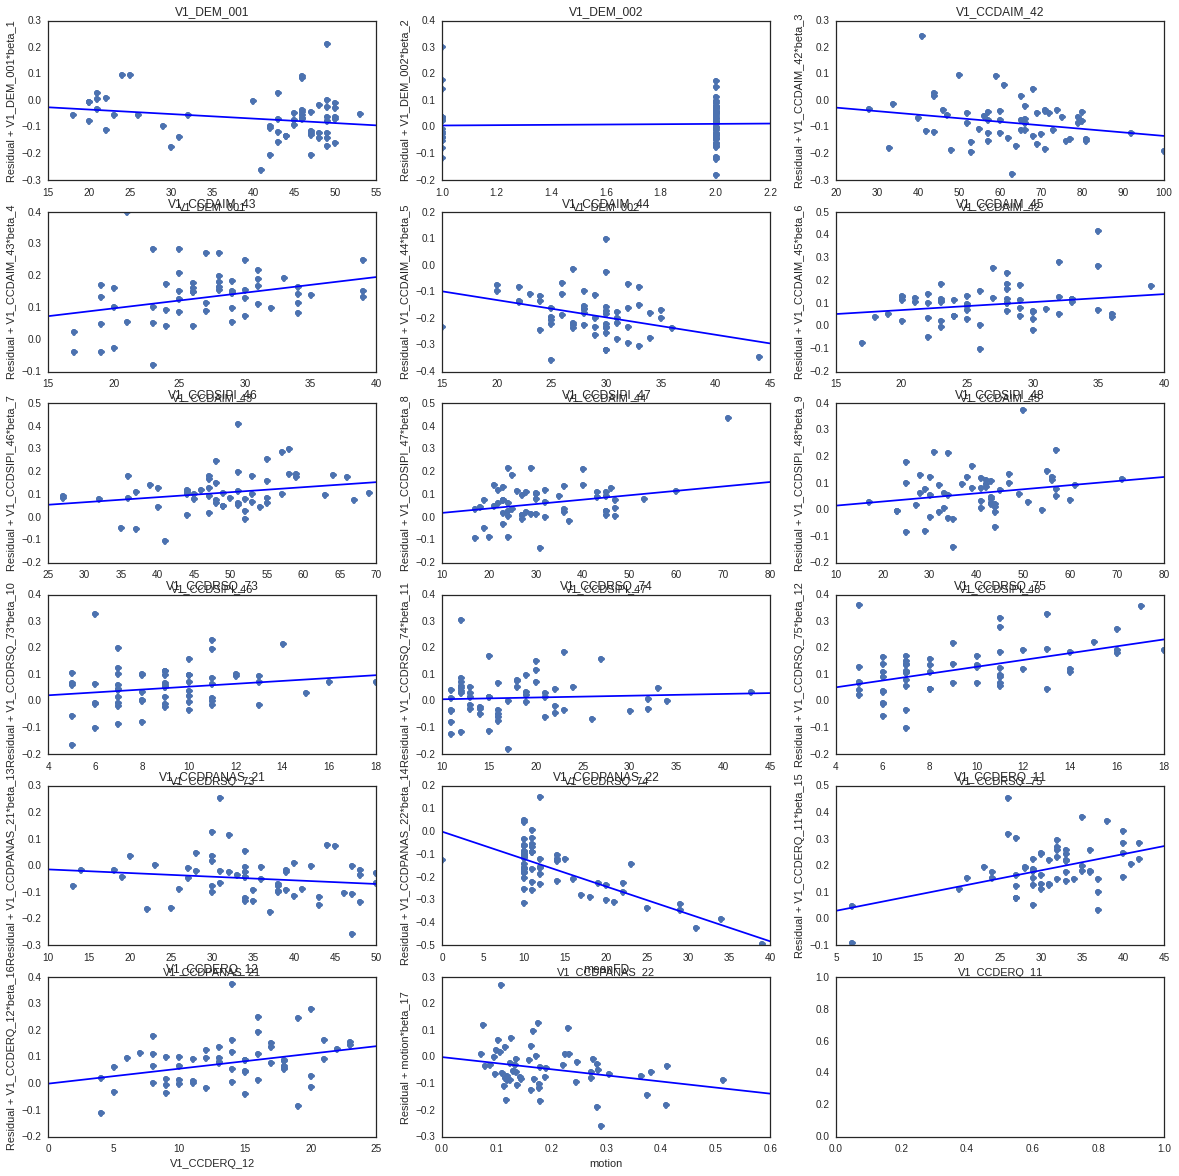

In [177]:

#phenotypic info
phenoFile='/home/jmuraskin/Projects/CCD/Pheno/narsad+vt_new.csv'

pheno=pd.read_csv(phenoFile)
pheno=pheno.set_index('participant').fillna(value=0)
subject_list=goodsubj

addmotion=True
phenoValues=['V1_DEM_001','V1_DEM_002','V1_CCDAIM_42','V1_CCDAIM_43','V1_CCDAIM_44','V1_CCDAIM_45','V1_CCDSIPI_46','V1_CCDSIPI_47','V1_CCDSIPI_48','V1_CCDRSQ_73','V1_CCDRSQ_74','V1_CCDRSQ_75','V1_CCDPANAS_21','V1_CCDPANAS_22','V1_CCDERQ_11','V1_CCDERQ_12']
# phenoValues=['V1_DEM_001','V1_DEM_002','V1_CCDAIM_41','V1_CCDSIPI_49','V1_CCDRSQ_72','V1_CCDPANAS_23','V1_CCDERQ_13','V1_DBDI_22']
# phenoValues=['V1_DEM_001','V1_DEM_002','V1_CCDPANAS_21','V1_CCDPANAS_22']
# phenoValues=['V1_DEM_001','V1_DEM_002','V1_CCDAIM_42','V1_CCDAIM_43','V1_CCDAIM_44','V1_CCDAIM_45']
# phenoValues=['V1_DEM_001','V1_DEM_002','V1_CCDRSQ_73','V1_CCDRSQ_74','V1_CCDRSQ_75']
# phenoValues=['V1_DEM_001','V1_DEM_002','V1_CCDSIPI_46','V1_CCDSIPI_47','V1_CCDSIPI_48']

# modelInfo=np.arctanh(GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='FEEDBACK'],axis=0)].groupby('Subject_ID').mean()['modelcorr'])
modelInfo=np.array(blockedDF[np.all([blockedDF.subj.isin(goodsubj),blockedDF.Condition=='Wander',blockedDF.FB=='FEEDBACK'],axis=0)]['average'])#-np.array(blockedDF[np.all([blockedDF.subj.isin(goodsubj),blockedDF.Condition=='Focus',blockedDF.FB=='FEEDBACK'],axis=0)]['std'])

motionInfo=GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='FEEDBACK'],axis=0)].groupby('Subject_ID').mean()['meanFD']

if addmotion:
    pheno=pheno.loc[subject_list][phenoValues]
    pheno['motion']=motionInfo
    modelX=pheno
else:
    modelX=pheno.loc[subject_list][phenoValues]

inputs=modelInfo
# inputs=array(fb_performance['R'])
# inputs=array(fb_coefs[fb_coefs.pe==3]['Coef'])
results=runRLMR(inputs,modelX,phenoValues + ['meanFD'],RLM=True)
# # coefs=np.array(fb_coefs['Coef']-nfb_coefs['Coef']).reshape(len(unique(GroupDF[GroupDF.Subject_ID.isin(goodsubj)]['Subject_ID'])),10)
# plt.scatter(pheno.loc[goodsubj][phenoValue],groupResults.FB_Wander-groupResults.noFB_Wander)
# pearsonr(pheno.loc[goodsubj][phenoValue],modelInfo)

In [ ]:
plt.figure()
sns.factorplot(data=GroupDF[GroupDF.Subject_ID.isin(goodsubj)],x='FB',y='pCorr_Wander',kind='strip',units='Subject',ci=68)
plt.figure()
sns.factorplot(data=GroupDF[GroupDF.Subject_ID.isin(goodsubj)],x='FB',y='pCorr_Focus',kind='bar',units='Subject',ci=68)

In [370]:
import nibabel as nib

In [416]:
img=nib.load('/home/jmuraskin/Temp/mask.nii.gz')

In [417]:
data=img.get_data()
newImg=np.zeros((61,73,61,408))
newImg[data==1]=GroupDF[np.all([GroupDF.Subject_ID=='CCD075',GroupDF.FB=='FEEDBACK'],axis=0)].RSN3

In [418]:
newImage = nib.Nifti1Image(newImg,img.get_affine())

nib.save(newImage,'/home/jmuraskin/Temp/RSN3.nii.gz')

In [443]:
RSN=pd.read_csv('/home/jmuraskin/Temp/RSN3.txt',header=None)
dRSN=pd.read_csv('/home/jmuraskin/Temp/despike.txt',header=None)
RSN_all=pd.read_csv('/home/jmuraskin/CCD-despike-regression/CCD_075_RSN10.txt',header=None,names=columnNames,delim_whitespace=True)

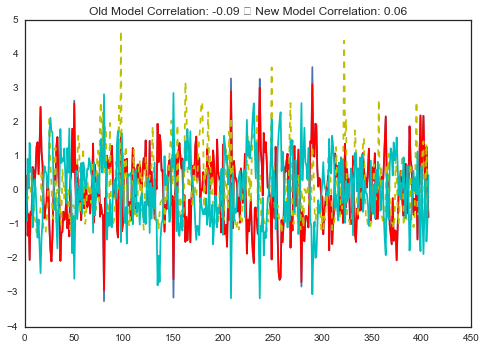

In [447]:
# plt.plot(RSN)
# plt.plot(dRSN,'r-')
plt.plot(zscore(GroupDF[np.all([GroupDF.Subject_ID=='CCD075',GroupDF.FB=='FEEDBACK'],axis=0)].fd),'y--')
plt.plot(zscore(RSN_all['RSN3']),'c')
plt.title('Old Model Correlation: %0.2f \t New Model Correlation: %0.2f' % (GroupDF[np.all([GroupDF.Subject_ID=='CCD075',GroupDF.FB=='FEEDBACK'],axis=0)].modelcorr.mean(),pearsonr(RSN_all['RSN3'],dmnIdeal['Wander']-dmnIdeal['Focus'])[0]))

In [472]:
results.rsquared_adj

-0.0040463719877001925

In [485]:
getCorrelationfromModel(df['RSN3'],fd)

TypeError: column_stack() takes exactly 1 argument (2 given)

In [503]:
fd=pd.read_csv(fdFilePath,header=None,names=['fd'],delim_whitespace=True)
df['meanFD']=fd.mean()[0]
fd[fd>.3]=1
fd[fd<1]=0
df['OLS_Rsquared']=getCorrelationfromModel(df['RSN3'],fd['fd'])

In [755]:
rois=pd.read_csv('/home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/paired-Ttest/all/cope1/rois.txt',header=None,delim_whitespace=True)

In [759]:
roisVals=rois.values
subjects=range(len(goodsubj))+range(len(goodsubj))
subjects=np.repeat(subjects,roisVals.shape[1])
fb=['FEEDBACK']*len(goodsubj)+['NOFEEDBACK']*len(goodsubj)
fb=np.repeat(fb,roisVals.shape[1])
ROIS=range(roisVals.shape[1])
ROIS=np.tile(ROIS,2*len(goodsubj))
# FB=roisVals[:36,:]
# nFB=roisVals[37:,:]

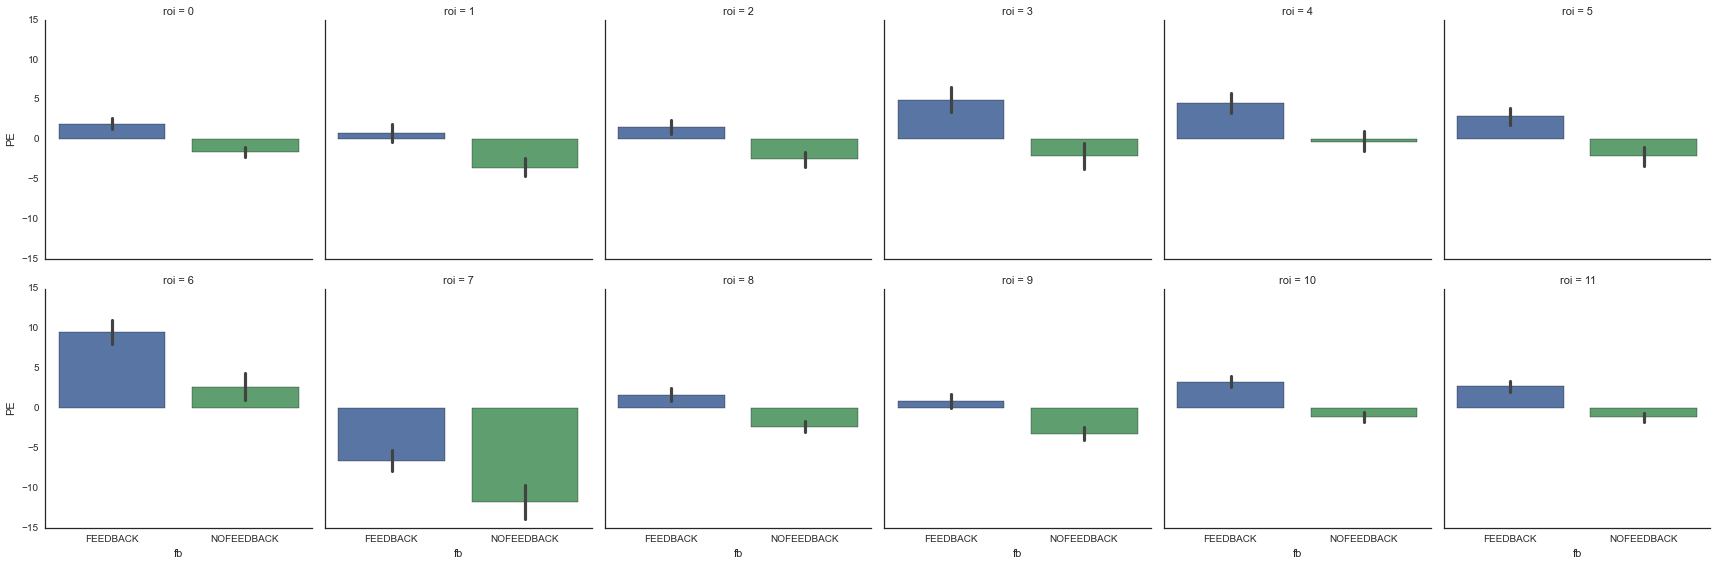

In [772]:
roi=pd.DataFrame({'PE':roisVals.flatten(),'subj':subjects,'roi':ROIS,'fb':fb})
# roi.head(20)
sns.factorplot(data=roi,y='PE',x='fb',units='subj',col='roi',col_wrap=6,ci=68,kind='bar')


In [783]:
pearsonr(roi[np.all([roi.fb=='FEEDBACK',roi.roi==3],axis=0)]['PE'],np.arctanh(GroupDF[np.all([GroupDF.Subject_ID.isin(goodsubj),GroupDF.FB=='FEEDBACK'],axis=0)].groupby('Subject_ID').mean()['modelcorr']))


(0.1359220229736901, 0.30042847676118623)

In [32]:
from surfer import Brain, io

"""Bring up the visualization"""
brain = Brain("fsaverage", "split", "inflated",
              views=['lat', 'med'], background="white")

"""Project the volume file and return as an array"""
mri_file = "/home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/paired-Ttest/all/cope1/cope1/cope1_tstat1.nii.gz"
reg_file = os.path.join(os.environ["FREESURFER_HOME"],
                        "average/mni152.register.dat")
surf_data_lh = io.project_volume_data(mri_file, "lh", reg_file)
surf_data_rh = io.project_volume_data(mri_file, "rh", reg_file)

"""
You can pass this array to the add_overlay method for a typical activation
overlay (with thresholding, etc.).
"""
brain.add_overlay(surf_data_lh, min=2.5, max=5, name="ang_corr_lh", hemi='lh')
brain.add_overlay(surf_data_rh, min=2.5, max=5, name="ang_corr_rh", hemi='rh')

"""
You can also pass it to add_data for more control
over the visualization. Here we'll plot the whole
range of correlations
"""
for overlay in brain.overlays_dict["ang_corr_lh"]:
    overlay.remove()
for overlay in brain.overlays_dict["ang_corr_rh"]:
    overlay.remove()

"""
We want to use an appropriate color map for these data: a divergent map that
is centered on 0, which is a meaningful transition-point as it marks the change
from negative correlations to positive correlations.

We'll also plot the map with some transparency so that we can see through to
the underlying anatomy.
"""
brain.add_data(surf_data_lh, 2.5, 5, colormap="hot", alpha=.75,
               hemi='lh')
brain.add_data(surf_data_rh, 2.5, 5, colormap="hot", alpha=.75,
               hemi='rh')

mri_vol2surf --mov /home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/paired-Ttest/all/cope1/cope1/cope1_tstat1.nii.gz --hemi lh --surf white --reg /opt/freesurfer/average/mni152.register.dat --projfrac-avg 0 1 0.1 --surf-fwhm 3 --o /tmp/pysurfer-v2s4MbxPh.mgz


INFO:surfer:mri_vol2surf --mov /home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/paired-Ttest/all/cope1/cope1/cope1_tstat1.nii.gz --hemi lh --surf white --reg /opt/freesurfer/average/mni152.register.dat --projfrac-avg 0 1 0.1 --surf-fwhm 3 --o /tmp/pysurfer-v2s4MbxPh.mgz


mri_vol2surf --mov /home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/paired-Ttest/all/cope1/cope1/cope1_tstat1.nii.gz --hemi rh --surf white --reg /opt/freesurfer/average/mni152.register.dat --projfrac-avg 0 1 0.1 --surf-fwhm 3 --o /tmp/pysurfer-v2seg5hgC.mgz


INFO:surfer:mri_vol2surf --mov /home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/paired-Ttest/all/cope1/cope1/cope1_tstat1.nii.gz --hemi rh --surf white --reg /opt/freesurfer/average/mni152.register.dat --projfrac-avg 0 1 0.1 --surf-fwhm 3 --o /tmp/pysurfer-v2seg5hgC.mgz
/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/mayavi/tools/camera.py:288: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [126]:
from pandas import read_csv
import numpy as np
runAll=1
perfSplit=1

motionTest=read_csv('/home/jmuraskin/Projects/CCD/CCD-scripts/analysis/CCD_meanFD.csv',names=['Subject_ID','FB','scanorder','meanFD'])

performance=read_csv('/home/jmuraskin/Projects/CCD/CCD-scripts/analysis/CCD_performance.csv',names=['Subject_ID','FB','scanorder','R'])

fbNames=['NOFEEDBACK','FEEDBACK']

if runAll:
    subject_list=np.unique(motionTest.Subject_ID)
    motionDir='all'
else:
    motionThresh=0.2
    allsubj=np.unique(motionTest['Subject_ID'])
    motionReject=np.unique((motionTest[motionTest.meanFD>motionThresh]['Subject_ID']))
    subject_list=np.setdiff1d(allsubj,motionReject)
    motionDir='motionThresh-%f' % motionThresh


if perfSplit>0:
    # sort by performance
    maxModel=performance[performance.Subject_ID.isin(subject_list)].groupby(['Subject_ID'])['R'].max().sort_values(ascending=False)
    sortedOrder=maxModel.index
    numSubjs=len(sortedOrder)
    numSubjsPerGroup=numSubjs/3
    if perfSplit==1:
        subject_list=np.array(sortedOrder[0:numSubjsPerGroup])
        perf_split_name='/Tier-1'


In [19]:
motion=read_csv('/home/jmuraskin/Projects/CCD/CPAC-out/pipeline_CCD_v1/CCD012_data_/motion_params/_scan_feedback_1/motion_parameters.txt',sep=',',index_col=False)

In [144]:
performance=pd.read_csv('/home/jmuraskin/Projects/CCD/CCD-scripts/analysis/CCD_performance.csv',names=['Subject_ID','FB','scanorder','R'])
perfSplit=1

fbNames=['NOFEEDBACK','FEEDBACK']

if runAll:
    subject_list=np.unique(motionTest.Subject_ID)
    motionDir='all'
else:
    motionThresh=0.2
    allsubj=np.unique(motionTest['Subject_ID'])
    motionReject=np.unique((motionTest[motionTest.meanFD>motionThresh]['Subject_ID']))
    subject_list=np.setdiff1d(allsubj,motionReject)
    motionDir='motionThresh-%f' % motionThresh


if perfSplit>0:
    # sort by performance
    maxModel=performance[performance.Subject_ID.isin(subject_list)].groupby(['Subject_ID'])['R'].max().sort_values(ascending=False)
    sortedOrder=maxModel.index
    numSubjs=len(sortedOrder)
    numSubjsPerGroup=numSubjs/4
    if perfSplit==1:
        subject_list=np.array(sortedOrder[0:numSubjsPerGroup])
    if perfSplit==3:
        subject_list=np.array(sortedOrder[-numSubjsPerGroup:])
        



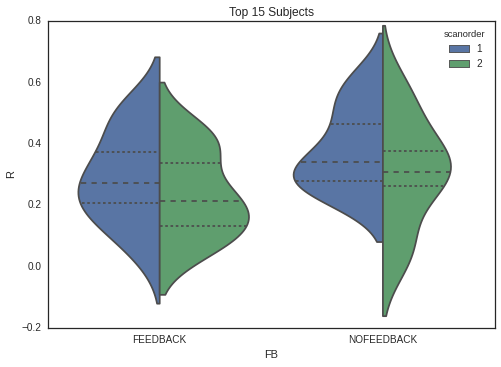

In [145]:
sns.violinplot(data=performance[performance.Subject_ID.isin(subject_list)],x='FB',y='R',hue='scanorder',split=True,units='Subject_ID',bw=.6,inner='quartile')
sns.plt.title('Top 15 Subjects')

In [121]:
from scipy.stats import ttest_1samp,ttest_ind
t,p=ttest_1samp(np.array(performance[np.all([performance.Subject_ID.isin(subject_list),performance.FB=='NOFEEDBACK',performance.scanorder==2],axis=0)]['R'])-np.array(performance[np.all([performance.Subject_ID.isin(subject_list),performance.FB=='FEEDBACK',performance.scanorder==1],axis=0)]['R']),0)
print t
print p
t,p=ttest_ind(np.array(performance[np.all([performance.Subject_ID.isin(subject_list),performance.FB=='NOFEEDBACK',performance.scanorder==2],axis=0)]['R']),np.array(performance[np.all([performance.Subject_ID.isin(subject_list),performance.FB=='FEEDBACK',performance.scanorder==2],axis=0)]['R']))
print t
print p

-0.3259872238
0.746697123096
0.383522301514
0.702734790203


In [102]:
meanVal=np.array(performance[np.all([performance.Subject_ID.isin(subject_list),performance.FB=='NOFEEDBACK',performance.scanorder==2],axis=0)]['R'])-np.array(performance[np.all([performance.Subject_ID.isin(subject_list),performance.FB=='FEEDBACK',performance.scanorder==1],axis=0)]['R'])
meanVal

array([ 0.27691863,  0.07246885,  0.13452744,  0.10100265,  0.22283582,
        0.11326881,  0.04951861, -0.1932613 , -0.21302029, -0.27972068])

In [141]:
df[rsn].to_csv('%s/%s_%s.csv' % (rsnDirectory,subj,'FEEDBACK' if row['SCAN_%d_FEEDBACK' % scan]==1 else 'NOFEEDBACK'),header=False)


In [146]:
from scipy.fftpack import rfft, irfft

# def phaseScrambleTS(ts):
#     """Returns a TS: original TS power is preserved; TS phase is shuffled."""
#     fs = rfft(ts)
#     # rfft returns real and imaginary components in adjacent elements of a real array
#     pow_fs = fs[1:-1:2]**2 + fs[2::2]**2
#     phase_fs = np.arctan2(fs[2::2], fs[1:-1:2])
#     phase_fsr = phase_fs.copy()
#     np.random.shuffle(phase_fsr)
#     # use broadcasting and ravel to interleave the real and imaginary components. 
#     # The first and last elements in the fourier array don't have any phase information, and thus don't change
#     fsrp = np.sqrt(pow_fs[:, np.newaxis]) * np.c_[np.cos(phase_fsr), np.sin(phase_fsr)]
#     fsrp = np.r_[fs[0], fsrp.ravel(), fs[-1]]
#     tsr = irfft(fsrp)
#     return tsr

In [172]:
r_scram=np.zeros((len(goodsubj),2))
nperms=1000
for fb_indx,fb in enumerate(['FEEDBACK','NOFEEDBACK']):
    for s_indx,subj in enumerate(goodsubj):
#         print 'Running subject %s #%d' % (fb,s_indx)
        ts=GroupDF[np.all([GroupDF['Subject_ID']==subj,GroupDF['FB']==fb],axis=0)]['RSN3']   
        rs=np.zeros((nperms,))
        for n in range(nperms):
            ts_scram=phaseScrambleTS(ts)
            rs[n]=pearsonr(ts_scram,dmnIdeal['Wander']-dmnIdeal['Focus'])[0]
        flat=rs.flatten()
        flat.sort()
        r_scram[s_indx,fb_indx]=flat[-50]



# plt.plot(range(408),ts,'b')
# plt.plot(range(408),ts_scram,'r')

In [163]:
# %matplotlib inline
# import matplotlib
# import numpy as np
# import matplotlib.pyplot as plt
from scipy.fftpack import rfft, irfft

def phaseScrambleTS(ts):
    """Returns a TS: original TS power is preserved; TS phase is shuffled."""
    fs = fft(ts)
    pow_fs = np.abs(fs) ** 2.
    phase_fs = np.angle(fs)
    phase_fsr = phase_fs.copy()
    phase_fsr_lh = phase_fsr[1:len(phase_fsr)/2]
    np.random.shuffle(phase_fsr_lh)
    phase_fsr_rh = -phase_fsr_lh[::-1]
    phase_fsr = np.append(phase_fsr[0],
                          np.append(phase_fsr_lh,
                                    np.append(phase_fsr[len(phase_fsr)/2],
                                              phase_fsr_rh)))
    fsrp = np.sqrt(pow_fs) * (np.cos(phase_fsr) + 1j * np.sin(phase_fsr))
    tsr = ifft(fsrp)
    return np.real(tsr)

# ts = np.array([0.02, -1.04, 2.50, 2.21, 1.37, -0.05, 0.06, -0.22, -0.48, -0.31, 0.15, 0.99, 0.39, 0.65, 1.13, 0.77, 1.16, 1.35, 0.92, 1.42, 1.58, 1.33, 0.73, 0.98, 0.66, 0.13, -0.19, 2.05, 1.95, 1.25, 1.37, 0.85, 0.00, 1.37, 2.17, 0.69, 1.38, 0.49, 0.52, 0.62, 1.74, 0.67, 0.61, 1.03, 0.38, 0.64, 0.83, 1.16, 1.10, 1.30, 1.98, 0.92, 1.36, -1.49, -0.80, -0.08, 0.01, -0.04, -0.07, -0.20, 0.82, -0.26, 0.83, 0.09, -0.54, -0.45, 0.82, -0.53, -0.88, -0.54, -0.30, 0.52, 0.54, -0.57, 0.73, -0.04, 0.34, 0.59, -0.67, -0.25, -0.44, 0.07, -1.00, -1.88, -2.55, -0.08, -1.13, -0.94, -0.09, -2.08, -1.56, 0.25, -1.87, 0.52, -0.51, -1.42, -0.80, -1.96, -1.42, -1.27, -1.08, -1.79, -0.73, -2.70, -1.14, -1.71, -0.75, -0.78, -1.87, -0.88, -2.15, -1.92, -2.17, -0.98, -1.52, -1.92], dtype=np.float)

# N = ts.shape[0]
# TR = 2.
# x = np.linspace(0.0, N*TR, N)
# plt.plot(x, ts)
# plt.ylabel('% Sig. Change')
# plt.xlabel('Time')
# plt.title('RSFC: Time domain')
# plt.show()

# ts_ps = phaseScrambleTS(ts)
# plt.plot(x, ts, x, ts_ps)
# plt.ylabel('% Sig. Change')
# plt.xlabel('Time')
# plt.title('RSFC, Orig. vs. Phase-Scrambled: Time domain')
# plt.show()

# fs = fft(ts)
# fs_ps = fft(ts_ps)
# xf = np.linspace(0.0, 1.0/(2.0*TR), N/2)
# plt.plot(xf, 2./N * np.abs(fs[0:N/2]), 'b--', xf, 2./N * np.abs(fs_ps[0:N/2]), 'g:')
# plt.grid()
# plt.ylabel('Amplitude')
# plt.xlabel('Freq.')
# plt.title('RSFC, Orig. vs. Phase-Scrambled: Freq. domain, Amp.')
# plt.show()

In [173]:
r_scram.mean(axis=0)

array([ 0.15428816,  0.18119359])

In [2]:
! git pull
import CCD_packages as CCD
reload(CCD)

Already up-to-date.


<module 'CCD_packages' from 'CCD_packages.pyc'>

In [3]:
CCD.make_pysurfer_images(folder='/home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/paired-Ttest/motionRMS-1.000000/cope5_age_gender/',suffix='cope5',coords=())

mri_vol2surf --mov /home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/paired-Ttest/motionRMS-1.000000/cope5_age_gender//thresholded_posneg.nii.gz --hemi lh --surf white --reg /opt/freesurfer/average/mni152.register.dat --projfrac-avg 0 1 0.1 --o /tmp/pysurfer-v2snpzXI5.mgz
mri_vol2surf --mov /home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/paired-Ttest/motionRMS-1.000000/cope5_age_gender//thresholded_posneg.nii.gz --hemi rh --surf white --reg /opt/freesurfer/average/mni152.register.dat --projfrac-avg 0 1 0.1 --o /tmp/pysurfer-v2s_soh4z.mgz


/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/mayavi/tools/camera.py:288: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

